참고: https://arxiv.org/pdf/1708.04396.pdf


# 개요

검색어-검색목록-딜클릭 정보로부터 아래와 같은 데이터가 배치로 생성중임.
* wmpga360.wmp_ga_anal.keyword_category_ (검색어-카테고리)
* wmpga360.wmp_ga_anal.keyword_prod_ (검색어-딜)

BiRank 알고리즘을 이용하여 구현하자.

장점
* 검색어-카테고리 관계를 보다 깊이 중첩시켜 활용
* 질의에 대한 조회후, 관련 카테고리 조사 외에, 관련 키워드 확보 가능

활용 아이디어

* 임계치 근방에서는 어차피 이질감 있는 카테고리가 얽힌다.
* 이를 방지 하기 위해 상위 카테고리를 공유하는지 정보를 활용하여 한번더 필터링 하면 어떨까 한다.

즉, 유사도가 

* $(c_1, 1]$ 까지는 전부 억셉트
* $(c_2, c_1]$ 까지는 2뎁스가 같아야 억셉트
* $(c_3, c_2]$ 까지는 3뎁스가 같아야 억셉트
* 그 아래는 4뎁스가 같아야 억셉트


## 크게 3가지 step
- BiRank
- 카테고리 안전장치
- clustering

---
---

In [1]:
import pandas as pd
import numpy as np

In [2]:
# 데이터

df = pd.read_csv("./keyword_category_201903.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697397 entries, 0 to 697396
Data columns (total 11 columns):
Unnamed: 0         697397 non-null int64
year               697397 non-null int64
month              697397 non-null int64
keyword            697397 non-null object
theme_id           697397 non-null int64
old_admin_cate1    697397 non-null object
old_admin_cate2    697397 non-null object
old_admin_cate3    697397 non-null object
old_admin_cate4    697397 non-null object
old_admin_cate5    697397 non-null object
cnt                697397 non-null int64
dtypes: int64(5), object(6)
memory usage: 58.5+ MB


## 기초조사

In [4]:
# 키워드-theme_id 수 (count)
keyword_theme_info = df[['keyword', 'theme_id']].groupby('keyword').count().sort_values(by='theme_id', ascending=False)

# keyword_theme_info['theme_id'].value_counts()

# 키워드-카운트 수 (sum)
keyword_count_info = df[['keyword', 'cnt']].groupby('keyword').sum().sort_values(by='cnt', ascending=False)

# keyword_count_info['theme_id'].value_counts()

In [5]:
keyword_theme_info

,theme_id
keyword,
33데이,577
반값특가,510
투데이특가,329
심야특가,296
랭킹특가,263
모닝특가,210
신상특가,167
게릴라특가,154
11시딜,146


In [6]:
keyword_count_info

,cnt
keyword,
해피머니,569963
마스크,280211
물티슈,277561
제주도 항공권,218606
반값특가,200557
미세먼지 마스크,184517
양말,172286
귀걸이,158108
컬쳐랜드,157229


# # 한달조사 (3월)
한달 조사 03월
검색어-클릭수 통계

- 14개 이상 클릭된 검색어: 230,747
- 7개 이상 클릭된 검색어: 402,182

3월에 대해서는 70개 이상의 tehme_id로 랜딩되는 검색어 26개는 제외한다.

(44특가, 투데이특가, 균일가, 44데이, 게릴라특가, 특가, 홈쇼핑, 나이키, 주말만물상, 심야특가, 패션뷰티픽, ...)

전처리

- 백만자리 숫자 제거
- 억자리 숫자 제거

### - 필터 - 70개 카테고리에서 검색된 검색어이거나, keyword_count가  14미만

In [7]:
filtered_set = set(keyword_theme_info[keyword_theme_info['theme_id']>=70].index) | set(keyword_count_info[keyword_count_info['cnt']<14].index)
def filter_keyword_fn(row):
    keyword = row['keyword']
    if keyword in filtered_set: # 너무 빈도가 크거나, 작은 것 제외
        return False
    if len(keyword) >= 4 and keyword.isdigit(): # 네자리 이상 숫자면 제외
        return False
    return True
m = df.apply(filter_keyword_fn, axis=1)
filtered_df = df[m]


In [8]:
filtered_df.reset_index(drop=True, inplace=True)

In [9]:
filtered_df.shape

(521413, 11)

In [12]:
filtered_df.head()

,Unnamed: 0,year,month,keyword,theme_id,old_admin_cate1,old_admin_cate2,old_admin_cate3,old_admin_cate4,old_admin_cate5,cnt
0,0,2019,3,해피머니,501020000,온라인상품군,이용권,생활쿠폰,생활쿠폰,생활쿠폰,562166
1,1,2019,3,제주도 항공권,305090000,여행상품군,제주,항공권(단품),항공권(단품),항공권(단품),200625
2,2,2019,3,물티슈,241020104,배송상품군,유아동/출산,물티슈,물티슈,물티슈 기타,183770
3,3,2019,3,마스크,237010401,배송상품군,생활/주방,건강/의료용품,실버/재활/의료용품,가정용 상비/구급용품,172779
4,4,2019,3,컬쳐랜드,501020000,온라인상품군,이용권,생활쿠폰,생활쿠폰,생활쿠폰,156777


In [10]:
filtered_df.keyword.nunique()

230521

In [11]:
filtered_df.theme_id.nunique()

1704

---

## # step : BiRank 적용


In [13]:
# i -> keyword 사전
# keyword -> i 사전
index_to_keyword = {}
keyword_to_index = {}

for k in set(filtered_df.keyword.values):
    i = len(index_to_keyword)
    index_to_keyword[i] = k
    keyword_to_index[k] = i


In [14]:
# i -> theme_id 사전
# theme_id -> i 사전
index_to_theme = {}
theme_to_index = {}
for th in set(filtered_df.theme_id.values):
    i = len(index_to_theme)
    index_to_theme[i] = th
    theme_to_index[th] = i

In [15]:
# 개발 목적 문자열 세팅
theme_names = {}
for _, row in filtered_df.iterrows():
    if row['theme_id'] not in theme_names:
        theme_names[row['theme_id']] = '_'.join((row['old_admin_cate1'], row['old_admin_cate2'], row['old_admin_cate3'], row['old_admin_cate4'], row['old_admin_cate5']))

In [16]:
# scipy.sparse.csr_matrix 를 만들기 위한 기초 데이터
rows, cols, vals = [], [], []

for _, row in filtered_df.iterrows():
    i = keyword_to_index[row['keyword']]
    j = theme_to_index[row['theme_id']]
    v = row['cnt']
    rows.append(i)
    cols.append(j)
    vals.append(v)

### 계산

K: 키워드 수

T: 테마 수

페이퍼: https://arxiv.org/pdf/1708.04396.pdf 의 "Algorithm 1"


scipy.sparse.csr_matrix로 쉽게 계산 가능

In [17]:
from scipy.sparse import csr_matrix, diags

In [18]:
# Sparse Matrix (K=68940, T=1626)
W = csr_matrix((vals, (rows, cols)), dtype=np.float)

In [19]:
W.shape

(230521, 1704)

---

In [29]:
diag_k = W.sum(axis=1)
Dk = diags(1.0 / np.sqrt(np.asarray(diag_k).flatten()), format='csr')

In [30]:
diag_t = W.sum(axis=0)
Dt = diags(1.0 / np.sqrt(np.asarray(diag_t).flatten()), format='csr')

In [31]:
S = Dk.dot(W).dot(Dt)

In [32]:
# S_t: transpose of S (T=1704, K=230521) 한달 (14회 이상 클릭 검색어)
# S_t: transpose of S (T=1715, K=401700) 한달 (7회 이상 클릭 검색어)
# S_t: transpose of S (T=1626, K=68940) 하루
S_ = S.transpose()

In [33]:
S_

<1704x230521 sparse matrix of type '<class 'numpy.float64'>'
	with 521413 stored elements in Compressed Sparse Column format>

---

- 연습

In [20]:
diag_k = W.sum(axis=1)

In [21]:
diag_k.shape

(230521, 1)

In [22]:
Dk = diags(1.0 / np.sqrt(np.asarray(diag_k).flatten()), format='csr')

In [23]:
Dk.toarray()

array([[0.15430335, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21320072, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00299931, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.26726124, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03555591,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.25819889]])

In [24]:
Dk.toarray().shape

(230521, 230521)

---

In [34]:
from numpy import linalg as LA

# BiRank loop
def BiRankLoop(S, S_, i, alpha=0.9, beta=0.9):  
    dimU, dimP = S.shape           ### U : keywords , P : theme 
    p_0 = np.zeros((dimP,), dtype=np.float)
    p_0[i] = 1.0
    u_0 = np.ones((dimU,), dtype=np.float) / dimU # 균등한 확률 갖도록 - 합이 1이된다
    
    # initialize
    p = np.ones((dimP,), dtype=np.float) / dimP # 초기에는 이렇게 균등하게?
    u = np.ones((dimU,), dtype=np.float) / dimU
    
    eps = 1e-5
    num_iter = 0
    while True:
        new_p = alpha * np.asarray(S_.dot(u)).flatten() + (1.0-alpha)*p_0
        new_u = beta * np.asarray(S.dot(p)).flatten() + (1.0-beta)*u_0
        num_iter += 1
        diff = LA.norm(new_p - p) + LA.norm(new_u - u)
        if diff < eps:
            return new_p, new_u, num_iter, diff    
        p = new_p
        u = new_u


### 테스트

In [35]:
theme_names[index_to_theme[200]]

'배송상품군_생활/주방_문구/사무용품_설치/제작_도장/인주'

In [36]:
p, u, _, _ = BiRankLoop(S, S_, 200)

In [37]:
p.shape

(1704,)

In [38]:
p.max()

0.2201991842096773

In [39]:
p.argmax()

200

---

In [40]:
p, u, _, _ = BiRankLoop(S, S_, 100)

In [41]:
p.max()

0.10610723331899023

In [42]:
p.argmax()

100

---

In [43]:
# 기여한 키워드 살펴보기
list(map(lambda x: (index_to_keyword[x], u[x]), np.argsort(u)[-5:]))

[('아이폰악세사리', 0.00667080680260541),
 ('단선방지보호캡', 0.007011065744221672),
 ('실리콘케이블프로텍터', 0.0072729213594708835),
 ('아이폰케이블보호캡', 0.008829206187460135),
 ('케이블보호캡', 0.011979465069786293)]

### 배치 계산

In [44]:
# i 와 모든 j 간 점수를 재는 함수
def query_similar_themes(i, lower_bound=0.03):
    scores,_,_,_ = BiRankLoop(S, S_, i)
    result = []
    max_ = scores.max() # 자기자신이겠지
    for j in reversed(np.argsort(scores)): # 큰 값의 argument들부터 사용하게끔
        if scores[j] < max_*lower_bound: # max값의 3% 안되면 버려!
            break
        else:
            result.append((j, scores[j]))
    return result      

In [45]:
# 모든 i 에 대해서 score를 취합
result_all = {}
for i in range(len(index_to_theme)):
    result_all[i] = query_similar_themes(i)   # default : 3퍼센트까지 저장

In [46]:
len(index_to_theme)

1704

In [47]:
# 결과를 알아볼 수 있게 프린트
def query_and_print_results(i):
    #print(index_to_theme[i], result_all[i][0][1], theme_names[index_to_theme[i]])
    for j, score_j in result_all[i]:
        print(index_to_theme[j], score_j, theme_names[index_to_theme[j]])

---

---

### 결과 저장

---

- 연습

In [91]:
rr = {}

In [94]:
rr[0] = [(0, 0.37096819045087415),
 (597, 0.13157376639665694),
 (600, 0.02966982394281338),
 (277, 0.026971022022921377),
 (599, 0.02306291348925249),
 (598, 0.013067597082858179)]

In [96]:
rr[1] = [(1, 0.15752609769229728),
 (4, 0.036901668793378334),
 (536, 0.025400662516042352),
 (1390, 0.02373511986445778)]

In [98]:
ind, scores = rr.items()

In [104]:
for i, scores in rr.items():
    print(i)

0
1


In [105]:
for i, scores in rr.items():
    print(scores)

[(0, 0.37096819045087415), (597, 0.13157376639665694), (600, 0.02966982394281338), (277, 0.026971022022921377), (599, 0.02306291348925249), (598, 0.013067597082858179)]
[(1, 0.15752609769229728), (4, 0.036901668793378334), (536, 0.025400662516042352), (1390, 0.02373511986445778)]


In [116]:
result_all[15]

[(15, 0.21206861807917182),
 (16, 0.0805486473122677),
 (20, 0.07324273425894498),
 (19, 0.028962924710899823),
 (23, 0.02705833652076218),
 (14, 0.023510298227536804),
 (21, 0.012618474162566035),
 (18, 0.010634558148659372)]

In [164]:
len(result_all)

1626

In [165]:
rr

{0: [(0, 0.37096819045087415),
  (597, 0.13157376639665694),
  (600, 0.02966982394281338),
  (277, 0.026971022022921377),
  (599, 0.02306291348925249),
  (598, 0.013067597082858179)],
 1: [(1, 0.15752609769229728),
  (4, 0.036901668793378334),
  (536, 0.025400662516042352),
  (1390, 0.02373511986445778)]}

In [167]:
for i, scores in rr.items():
    print(i, scores)
    print('\n')

0 [(0, 0.37096819045087415), (597, 0.13157376639665694), (600, 0.02966982394281338), (277, 0.026971022022921377), (599, 0.02306291348925249), (598, 0.013067597082858179)]


1 [(1, 0.15752609769229728), (4, 0.036901668793378334), (536, 0.025400662516042352), (1390, 0.02373511986445778)]




In [169]:
scores[0][1]

0.15752609769229728

- 연습 끝

---

In [51]:
# big-query 등에 저장할 csv 생성 단계
ind = [] # 몇번째 카테고리인지?
vec_i = []
vec_j = []
vec_score = []
vec_score_percent = []
vec_names = []

for i, scores in result_all.items():
    #vec_i.append(index_to_theme[i])
    #vec_j.append(index_to_theme[i])
    #vec_score.append( scores[0] )
    #vec_names.append(theme_names[index_to_theme[i]])
    score_i = scores[0][1]
    for j, score in scores:
        ind.append(i) # 몇번째 카테고리인지 말해준다!
        vec_i.append(index_to_theme[i])
        vec_j.append(index_to_theme[j])
        vec_score.append(score)
        vec_score_percent.append( score/score_i )
        vec_names.append(theme_names[index_to_theme[j]])
        
result_df = pd.DataFrame.from_dict({'index':ind, 'i':vec_i, 'j':vec_j, 
                                    'score':vec_score, 'score_percent': vec_score_percent,
                                    'theme_names':vec_names})

In [52]:
result_df.to_excel("./0503_result.xlsx", encoding = 'utf-8-sig')

In [53]:
index_to_theme

{0: 237060101,
 1: 237060102,
 2: 237060103,
 3: 237060104,
 4: 237060105,
 5: 237060106,
 6: 103030800,
 7: 235020304,
 8: 232063001,
 9: 232071202,
 10: 232071206,
 11: 232071207,
 12: 232071208,
 13: 103071800,
 14: 101032000,
 15: 101040200,
 16: 104120400,
 17: 106070100,
 18: 101060600,
 19: 232030310,
 20: 237060201,
 21: 237060202,
 22: 237060203,
 23: 237060204,
 24: 237060205,
 25: 237060206,
 26: 237060207,
 27: 237060208,
 28: 237060209,
 29: 237060210,
 30: 235020401,
 31: 235020403,
 32: 235020405,
 33: 232063102,
 34: 232063103,
 35: 232063106,
 36: 232063107,
 37: 232063108,
 38: 232071303,
 39: 101040300,
 40: 106070200,
 41: 232030401,
 42: 232030402,
 43: 103121100,
 44: 237060301,
 45: 232063201,
 46: 232071403,
 47: 232071405,
 48: 232071406,
 49: 232071407,
 50: 301130000,
 51: 101040400,
 52: 106070300,
 53: 232030504,
 54: 237060401,
 55: 237060402,
 56: 237060403,
 57: 237060404,
 58: 239010101,
 59: 239010102,
 60: 232063302,
 61: 232071501,
 62: 232071502,
 6

---

## # step : 안전장치  -  카테고리 detph 로 점수의 기준을 달리 적용하자
- '대분류' 가 다르다면 점수의 기준을 까다롭게 적용하자(이런 느낌)

## cf. depth 별로 nunique 따져보자!

In [203]:
theme_id_df = pd.DataFrame(filtered_df.theme_id.unique(), dtype='str')

In [204]:
theme_id_df.columns = ['theme_id']

In [205]:
theme_id_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1626 entries, 0 to 1625
Data columns (total 1 columns):
theme_id    1626 non-null object
dtypes: object(1)
memory usage: 12.8+ KB


In [206]:
theme_id_df.apply(lambda x: x[:2]) # 기대했던건 이게 아닌데

,theme_id
0,239010304
1,101030400


In [207]:
'239010304'[:2] # 기대했던 형태

'23'

In [218]:
# depth5
theme_id_df['depth5'] = theme_id_df.theme_id.apply(lambda x: x[:1]) # 이렇게 series기준으로 하니깐 되는구나.

In [219]:
# depth4
theme_id_df['depth4'] = theme_id_df.theme_id.apply(lambda x: x[1:3])

In [220]:
# depth3
theme_id_df['depth3'] = theme_id_df.theme_id.apply(lambda x: x[3:5])

In [221]:
# depth2
theme_id_df['depth2'] = theme_id_df.theme_id.apply(lambda x: x[5:7])

In [222]:
# depth1
theme_id_df['depth1'] = theme_id_df.theme_id.apply(lambda x: x[7:9])

In [223]:
theme_id_df.head()

,theme_id,depth5,depth4,depth3,depth2,depth1
0,239010304,2,39,01,03,04
1,101030400,1,01,03,04,00
2,302240000,3,02,24,00,00
3,403040000,4,03,04,00,00
4,407040000,4,07,04,00,00


In [224]:
theme_id_df.depth4.nunique()

26

In [225]:
theme_id_df.depth3.nunique()

32

In [226]:
theme_id_df.depth2.nunique()

36

In [227]:
theme_id_df.depth1.nunique()

36

---

## # cf. 233120101 : 스마트 액세서리

In [228]:
tmp_ = [233120101
,233120304
,244010301
,233110502
,233120310
,233120305
,233120309
,233090307
,233120203
,244030301
,244020301
,233110201
,238050202
,233120202
,233030601
,233120308
,233120201
,233030602
,233040124
,233110801
,233120303
,233110401
,233120306
,233110501
,233040125
,233040112
,233120302]

In [239]:
tmp_score = [0.206190864
,0.02239435
,0.018756012
,0.018323451
,0.016499308
,0.012152716
,0.011425131
,0.007741347
,0.007370328
,0.007338403
,0.007207672
,0.006193015
,0.006144124
,0.006007762
,0.005871513
,0.00579441
,0.004407318
,0.003897168
,0.003771921
,0.003743832
,0.003215266
,0.003036639
,0.002699552
,0.002685238
,0.002635877
,0.002180863
,0.002062346]

In [250]:
tmp_df = pd.DataFrame({'theme_id':tmp_, 'score':tmp_score})

In [251]:
tmp_df.theme_id = tmp_df.theme_id.astype('str')

---

In [252]:
# 해당 thmeme_id만 있는 데이터 빼오기.
tmp_df = tmp_df.merge(theme_id_df, on='theme_id')

In [254]:
tmp_df.head()

,theme_id,score,depth5,depth4,depth3,depth2,depth1
0,233120101,0.206191,2,33,12,01,01
1,233120304,0.022394,2,33,12,03,04
2,244010301,0.018756,2,44,01,03,01
3,233110502,0.018323,2,33,11,05,02
4,233120310,0.016499,2,33,12,03,10


In [256]:
tmp_df['score_percentage'] = tmp_df.score/tmp_df.score.max()

In [258]:
tmp_df.columns

Index(['theme_id', 'score', 'depth5', 'depth4', 'depth3', 'depth2', 'depth1',
       'score_percentage'],
      dtype='object')

In [259]:
tmp_df = tmp_df[['theme_id', 'score', 'score_percentage', 'depth5', 'depth4', 'depth3', 'depth2', 'depth1']]

In [261]:
tmp_df

,theme_id,score,score_percentage,depth5,depth4,depth3,depth2,depth1
0,233120101,0.206191,1.000000,2,33,12,01,01
1,233120304,0.022394,0.108610,2,33,12,03,04
2,244010301,0.018756,0.090964,2,44,01,03,01
3,233110502,0.018323,0.088866,2,33,11,05,02
4,233120310,0.016499,0.080020,2,33,12,03,10
5,233120305,0.012153,0.058939,2,33,12,03,05
6,233120309,0.011425,0.055410,2,33,12,03,09
7,233090307,0.007741,0.037545,2,33,09,03,07
8,233120203,0.007370,0.035745,2,33,12,02,03
9,244030301,0.007338,0.035590,2,44,03,03,01


---

## cf. result_df에 depth를 만들어보자

In [55]:
result_df.head(10)

,index,i,j,score,score_percent,theme_names
0,0,237060101,237060101,0.346323,1.000000,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_롤화장지/물티슈/곽티슈
1,0,237060101,241020104,0.134240,0.387616,배송상품군_유아동/출산_물티슈_물티슈_물티슈 기타
2,0,237060101,241020107,0.032653,0.094286,배송상품군_유아동/출산_물티슈_물티슈_페넬로페
3,0,237060101,241010102,0.027892,0.080538,배송상품군_유아동/출산_기저귀/분유_기저귀_기저귀 기타
4,0,237060101,241020106,0.024595,0.071017,배송상품군_유아동/출산_물티슈_물티슈_순둥이
5,0,237060101,241020101,0.014352,0.041441,배송상품군_유아동/출산_물티슈_물티슈_기능성물티슈
6,1,237060102,237060102,0.154426,1.000000,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_방향제
7,1,237060102,237060105,0.033948,0.219832,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_탈취제
8,1,237060102,231050105,0.025179,0.163049,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_허브/아로마 선물용품
9,1,237060102,238050102,0.019831,0.128418,배송상품군_스포츠/자동차_자동차/오토바이용품_공기청정/세차용품_차량용공기청정용품


In [56]:
# j-column을 str로 바꿔주고 이용하자
result_df['j'] = result_df['j'].astype('str')

In [57]:
# depth5
result_df['depth5'] = result_df['j'].apply(lambda x: x[:1]) # 이렇게 series기준으로 하니깐 되는구나.

In [58]:
# depth4
result_df['depth4'] = result_df['j'].apply(lambda x: x[1:3])

In [59]:
# depth3
result_df['depth3'] = result_df['j'].apply(lambda x: x[3:5])

In [60]:
# depth2
result_df['depth2'] = result_df['j'].apply(lambda x: x[5:7])

In [61]:
# depth1
result_df['depth1'] = result_df['j'].apply(lambda x: x[7:9])

In [62]:
result_df.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
0,0,237060101,237060101,0.346323,1.000000,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_롤화장지/물티슈/곽티슈,2,37,06,01,01
1,0,237060101,241020104,0.134240,0.387616,배송상품군_유아동/출산_물티슈_물티슈_물티슈 기타,2,41,02,01,04
2,0,237060101,241020107,0.032653,0.094286,배송상품군_유아동/출산_물티슈_물티슈_페넬로페,2,41,02,01,07
3,0,237060101,241010102,0.027892,0.080538,배송상품군_유아동/출산_기저귀/분유_기저귀_기저귀 기타,2,41,01,01,02
4,0,237060101,241020106,0.024595,0.071017,배송상품군_유아동/출산_물티슈_물티슈_순둥이,2,41,02,01,06


In [63]:
# 위의,  233120101 : 스마트 액세서리
result_df[result_df['i'] == 233120101]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
276,64,233120101,233120101,0.207329,1.000000,배송상품군_디지털/가전_휴대폰/액세서리_스마트 액세서리_스마트 액세서리,2,33,12,01,01
277,64,233120101,233120304,0.020432,0.098549,배송상품군_디지털/가전_휴대폰/액세서리_휴대폰/태블릿 액세서리_기타 휴대폰 액세서리,2,33,12,03,04
278,64,233120101,233120310,0.015855,0.076471,배송상품군_디지털/가전_휴대폰/액세서리_휴대폰/태블릿 액세서리_휴대폰 케이스,2,33,12,03,10
279,64,233120101,244010301,0.015624,0.075358,배송상품군_잡화_국내브랜드_시계_패션시계,2,44,01,03,01
280,64,233120101,233110502,0.013618,0.065684,배송상품군_디지털/가전_태블릿/음향기기_이어폰/헤드폰/스피커_이어폰,2,33,11,05,02
281,64,233120101,233120309,0.013319,0.064241,배송상품군_디지털/가전_휴대폰/액세서리_휴대폰/태블릿 액세서리_휴대폰 케이블/젠더,2,33,12,03,09
282,64,233120101,233120305,0.011216,0.054097,배송상품군_디지털/가전_휴대폰/액세서리_휴대폰/태블릿 액세서리_보호필름/스티커,2,33,12,03,05
283,64,233120101,233090307,0.008507,0.041032,배송상품군_디지털/가전_카메라/액세서리_액세서리_삼각대,2,33,09,03,07
284,64,233120101,233110201,0.008054,0.038848,배송상품군_디지털/가전_태블릿/음향기기_게임 액세서리_게임 액세서리,2,33,11,02,01
285,64,233120101,233120203,0.007774,0.037497,배송상품군_디지털/가전_휴대폰/액세서리_휴대폰 주변기기_휴대폰 충전기,2,33,12,02,03


---

### - theme_id( column "i" ) 으로 groupby

In [64]:
result_df_grp = [grp[1] for grp in result_df.groupby('i')]

In [65]:
len(result_df_grp)

1704

### - result_df_grp 내에서, i와의 depth5/depth4 다른애들은 어느정도?

In [66]:
result_df_grp[0]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00


In [67]:
result_df_grp[1][0:1].depth4.values[0]

'01'

In [68]:
result_df_grp[1].depth4

3281    01
3282    01
3283    01
Name: depth4, dtype: object

In [69]:
(result_df_grp[1][0:1].depth4.values[0] != result_df_grp[1].depth4)

3281    False
3282    False
3283    False
Name: depth4, dtype: bool

In [70]:
result_df_grp[1][0:1]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
3281,542,101010200,101010200,0.128013,1.0,서비스상품군_음식_한식_갈비/삼겹살_갈비/삼겹살,1,01,01,02,00


In [71]:
# 갈비/삼겹살 카테고리에 대한 거였어 - depth4 / depth5 다른 결과들은?

result_df_grp[1][(result_df_grp[1][0:1].depth5.values[0] != result_df_grp[1].depth5) | 
                 (result_df_grp[1][0:1].depth4.values[0] != result_df_grp[1].depth4)]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1


In [72]:
# 위의 결과에, 10% score규모 가진애들은? - 없네.
result_df_grp[1][((result_df_grp[1][0:1].depth5.values[0] != result_df_grp[1].depth5) | 
                 (result_df_grp[1][0:1].depth4.values[0] != result_df_grp[1].depth4)) &
                 (result_df_grp[1].score_percent > 0.1)]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1


---

In [74]:
result_df_grp[0]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00


In [75]:
result_df_grp[0][((result_df_grp[0][0:1].depth5.values[0] != result_df_grp[0].depth5) | 
                                              (result_df_grp[0][0:1].depth4.values[0] != result_df_grp[0].depth4))]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1


In [76]:
result_df_grp[0][(result_df_grp[0][0:1].depth5.values[0] != result_df_grp[0].depth5) | 
                                              (result_df_grp[0][0:1].depth4.values[0] != result_df_grp[0].depth4)]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1


---

# # 4월 18일 --- *조사단계

## cf. '배송상품군' 제외하고 살펴볼까?

In [514]:
len(result_df_grp)

1626

In [541]:
not_delivery = pd.DataFrame()
for df in result_df_grp:  ## 리스트다.
    if df.head(1).depth5.item() != '2':
        not_delivery = pd.concat([not_delivery, df], axis=0)

In [542]:
not_delivery.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
7966,490,101010100,101010100,0.123840,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
7967,490,101010100,101030500,0.008259,0.066692,서비스상품군_음식_일식/수산물_해물찜/탕전문_해물찜/탕전문,1,01,03,05,00
7968,490,101010100,101140100,0.006056,0.048903,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
7969,490,101010100,101030400,0.004493,0.036285,서비스상품군_음식_일식/수산물_참치전문점_참치전문점,1,01,03,04,00
7970,490,101010100,101040300,0.004422,0.035711,서비스상품군_음식_분식_떡볶이전문_떡볶이전문,1,01,04,03,00


In [531]:
result_df.shape

(27948, 11)

In [543]:
not_delivery.shape # 

(2835, 11)

In [545]:
# 다른 객체들 구분 할 수 있는 '숫자' 만들어주기

no = []
for i,x in enumerate(not_delivery['index']):
    #print(x)
    if i == 0:
        no.append(0)
    else:
        if not_delivery['index'].values[i-1] != x:
            no.append(no[i-1]+1)
        else:
            no.append(no[i-1])

In [546]:
len(no)

2835

In [547]:
not_delivery['index_no'] = no

In [548]:
not_delivery.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
7966,490,101010100,101010100,0.123840,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00,0
7967,490,101010100,101030500,0.008259,0.066692,서비스상품군_음식_일식/수산물_해물찜/탕전문_해물찜/탕전문,1,01,03,05,00,0
7968,490,101010100,101140100,0.006056,0.048903,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00,0
7969,490,101010100,101030400,0.004493,0.036285,서비스상품군_음식_일식/수산물_참치전문점_참치전문점,1,01,03,04,00,0
7970,490,101010100,101040300,0.004422,0.035711,서비스상품군_음식_분식_떡볶이전문_떡볶이전문,1,01,04,03,00,0


### - 같은 cluster 안에서, 다른 category 애들의 상대점수 분포는?

In [549]:
not_delivery.index_no.max()

245

- <u>depth5 혹은 depth 4가 head(1)과 다른것

In [551]:
not_delivery_grp = [grp[1] for grp in not_delivery.groupby('index_no')]

In [564]:
# 이런식으로 해보자.
ext = not_delivery_grp[0][(not_delivery_grp[0].depth5 != not_delivery_grp[0].head(1).depth5.item()) |
                   (not_delivery_grp[0].depth4 != not_delivery_grp[0].head(1).depth4.item())]

In [565]:
ext

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
7971,490,101010100,106030700,0.003863,0.031196,서비스상품군_관광/여가/오락_연극/영화/극장_영화관_영화관,1,06,03,07,00,0
7978,490,101010100,403030000,0.001978,0.015975,공연상품군_연극_멜로/애정/로멘스_멜로/애정/로멘스_멜로/애정/로멘스,4,03,03,00,00,0
7979,490,101010100,403070000,0.001971,0.015919,공연상품군_연극_범죄_범죄_범죄,4,03,07,00,00,0
7982,490,101010100,403050000,0.001734,0.014005,공연상품군_연극_코미디_코미디_코미디,4,03,05,00,00,0
7983,490,101010100,301130000,0.001733,0.013993,여행상품군_국내_체혐_체혐_체혐,3,01,13,00,00,0
7985,490,101010100,303000000,0.001672,0.013505,여행상품군_국내성인_국내성인_국내성인_국내성인,3,03,00,00,00,0
7986,490,101010100,301030000,0.001614,0.013035,여행상품군_국내_레져/레포츠_레져/레포츠_레져/레포츠,3,01,03,00,00,0
7988,490,101010100,106070100,0.001478,0.011931,서비스상품군_관광/여가/오락_놀이/여가/취미_종합위락시설_종합위락시설,1,06,07,01,00,0
7989,490,101010100,403010000,0.001322,0.010678,공연상품군_연극_드라마_드라마_드라마,4,03,01,00,00,0
7991,490,101010100,410010000,0.001315,0.010620,공연상품군_키즈_어린이뮤지컬_어린이뮤지컬_어린이뮤지컬,4,10,01,00,00,0


In [562]:
len(not_delivery_grp)

246

In [566]:
# 군집 주체랑 다른 '카테고리'애들 저장하고 살펴보자.

not_delivery_ext = pd.DataFrame()

for df in not_delivery_grp:
    ext = df[(df.depth5 != df.head(1).depth5.item()) |
                   (df.depth4 != df.head(1).depth4.item())] 
    
    not_delivery_ext = pd.concat([not_delivery_ext, ext], axis=0) # 저장

In [569]:
import matplotlib.pyplot as plt

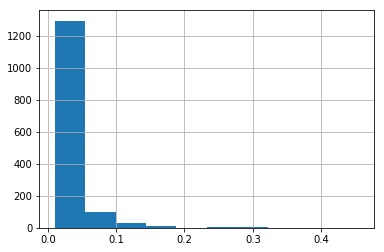

In [570]:
not_delivery_ext.score_percent.hist()

In [571]:
not_delivery_ext.score_percent.describe()

count    1443.000000
mean        0.027513
std         0.030535
min         0.010009
25%         0.012630
50%         0.017157
75%         0.028662
max         0.455444
Name: score_percent, dtype: float64

In [573]:
# 상대적 score 0.1이상인건, 3%정도밖에 안돼
not_delivery_ext[not_delivery_ext.score_percent >= 0.1].shape[0] / not_delivery_ext.shape[0]

0.03257103257103257

In [575]:
not_delivery_ext[not_delivery_ext.score_percent >= 0.1].shape

(47, 12)

In [581]:
not_delivery_ext[not_delivery_ext.score_percent >= 0.1].head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
15610,925,101012100,501020000,0.016383,0.152291,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00,9
14329,852,101110100,103010800,0.031805,0.235770,서비스상품군_생활서비스_이/미용/건강_마사지_마사지,1,03,01,08,00,47
14330,852,101110100,106071000,0.014670,0.108751,서비스상품군_관광/여가/오락_놀이/여가/취미_기타오락관련산업_기타오락관련산업,1,06,07,10,00,47
14331,852,101110100,103070400,0.014549,0.107849,서비스상품군_생활서비스_물품기기대여_도서/만화대여_도서/만화대여,1,03,07,04,00,47
15592,924,101110400,106071000,0.029144,0.155781,서비스상품군_관광/여가/오락_놀이/여가/취미_기타오락관련산업_기타오락관련산업,1,06,07,10,00,50


In [579]:
not_delivery_ext[not_delivery_ext.score_percent >= 0.1].index_no.unique()

array([  9,  47,  50,  69,  71,  72,  73,  83,  90,  91,  92,  95,  96,
        97, 101, 102, 111, 113, 117, 128, 140, 142, 143, 157, 160, 161,
       162, 166, 174, 181, 184, 197, 198, 200, 208, 223, 240])

In [585]:
not_delivery_ext[not_delivery_ext.score_percent >= 0.1].index

Int64Index([15610, 14329, 14330, 14331, 15592, 15593, 25289,  4212,  6426,
             7415, 15279, 23950, 25145, 26691, 26692,  5241,  5524, 13893,
             3523,  2423,  2424,  4568, 25818,  2455,  8497,  2354,  2356,
             5554,  5555,  4217, 24719, 24720, 24722, 23635,  5536, 19949,
            19950,   370, 22266, 21960, 10727,  6502, 18465,  1778,  1330,
            27932, 20068],
           dtype='int64')

In [583]:
not_delivery_ext[(not_delivery_ext.score_percent >= 0.1) &
                (not_delivery_ext.index_no == 9)]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
15610,925,101012100,501020000,0.016383,0.152291,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00,9


In [580]:
not_delivery_grp[9]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
15609,925,101012100,101012100,0.107578,1.000000,서비스상품군_음식_한식_기타고기요리_기타고기요리,1,01,01,21,00,9
15610,925,101012100,501020000,0.016383,0.152291,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00,9
15611,925,101012100,101110100,0.003396,0.031568,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00,9
15612,925,101012100,301140000,0.001425,0.013242,여행상품군_국내_기타_기타_기타,3,01,14,00,00,9
15613,925,101012100,103010800,0.001112,0.010340,서비스상품군_생활서비스_이/미용/건강_마사지_마사지,1,03,01,08,00,9


In [588]:
not_delivery_ext[(not_delivery_ext.score_percent >= 0.1) &
                (not_delivery_ext.index_no == 95)]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
5241,360,103090200,112081800,0.029387,0.172295,서비스상품군_교통/운송_화물취급/보관창고_화학물창고_화학물창고,1,12,08,18,00,95


In [582]:
not_delivery_grp[47]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
14328,852,101110100,101110100,0.134899,1.000000,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00,47
14329,852,101110100,103010800,0.031805,0.235770,서비스상품군_생활서비스_이/미용/건강_마사지_마사지,1,03,01,08,00,47
14330,852,101110100,106071000,0.014670,0.108751,서비스상품군_관광/여가/오락_놀이/여가/취미_기타오락관련산업_기타오락관련산업,1,06,07,10,00,47
14331,852,101110100,103070400,0.014549,0.107849,서비스상품군_생활서비스_물품기기대여_도서/만화대여_도서/만화대여,1,03,07,04,00,47
14332,852,101110100,101110400,0.011542,0.085563,서비스상품군_음식_다방/커피숍/카페_보드게임카페_보드게임카페,1,01,11,04,00,47
14333,852,101110100,103010300,0.010760,0.079763,서비스상품군_생활서비스_이/미용/건강_비만/피부관리_비만/피부관리,1,03,01,03,00,47
14334,852,101110100,501020000,0.008387,0.062175,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00,47
14335,852,101110100,101110200,0.007278,0.053953,서비스상품군_음식_다방/커피숍/카페_커피전문점_커피전문점,1,01,11,02,00,47
14336,852,101110100,106070100,0.006206,0.046005,서비스상품군_관광/여가/오락_놀이/여가/취미_종합위락시설_종합위락시설,1,06,07,01,00,47
14337,852,101110100,106020100,0.005119,0.037950,서비스상품군_관광/여가/오락_무도/유흥/가무_노래방/멀티방_노래방/멀티방,1,06,02,01,00,47


In [576]:
# 상대적 score 0.05이상인건, 11%정도밖에 안돼
not_delivery_ext[not_delivery_ext.score_percent >= 0.05].shape[0] / not_delivery_ext.shape[0]

0.11434511434511435

In [577]:
not_delivery_ext[not_delivery_ext.score_percent >= 0.05].shape[0] # 165개

165

---

In [550]:
not_delivery.to_excel('not_delivery_cate_0418.xlsx')

---

In [629]:
result_df.shape

(27948, 11)

## cf. '배송상품군'  살펴볼까?

In [589]:
len(result_df_grp)

1626

In [637]:
delivery = pd.DataFrame()
for df in result_df_grp:  ## 리스트다. (딕셔너리면 튜플 형태로 받아야겠지)
    if df.head(1).depth5.item() == '2':
        
        # 다른 category인지 아닌지 변수로 선언해준다 - depth4 혹은 depth5 가 다르다면, 다른 category이다.
        #df = df[df.score_percent >= 0.02] # 그냥 밑에서 완성된 결과에 해줘도 된다.
        df['other_cate'] = ( (df.depth5 != df.head(1).depth5.item()) | (df.depth4 != df.head(1).depth4.item()) )
        delivery = pd.concat([delivery, df], axis=0)

In [641]:
delivery.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,other_cate
12405,744,231010101,231010101,0.147850,1.000000,배송상품군_가구/홈/데코_가구/DIY_가구리폼_DIY가구/가구리폼,2,31,01,01,01,False
12406,744,231010101,237040304,0.008627,0.058349,배송상품군_생활/주방_생활용품_수납정리_선반/진열대,2,37,04,03,04,True
12407,744,231010101,237040202,0.007965,0.053875,배송상품군_생활/주방_생활용품_디지털도어락/보안용품_호신용품/보안,2,37,04,02,02,True
12408,744,231010101,102070100,0.007330,0.049574,서비스상품군_소매_가정/주방/인테리어_인테리어/욕실용품/커튼_인테리어/욕실용품/커튼,1,02,07,01,00,True
12409,744,231010101,231050303,0.006123,0.041417,배송상품군_가구/홈/데코_조명/인테리어_홈리뉴얼_시트지,2,31,05,03,03,False


---

In [594]:
result_df.shape

(27948, 11)

In [595]:
delivery.shape # 

(25113, 11)

In [643]:
# 다른 객체들 구분 할 수 있는 '숫자' 만들어주기

no = []
for i,x in enumerate(delivery['index']):
    #print(x)
    if i == 0:
        no.append(0)
    else:
        if delivery['index'].values[i-1] != x:
            no.append(no[i-1]+1)
        else:
            no.append(no[i-1])

In [644]:
len(no)

25113

In [645]:
delivery['index_no'] = no

In [646]:
delivery.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,other_cate,index_no
12405,744,231010101,231010101,0.147850,1.000000,배송상품군_가구/홈/데코_가구/DIY_가구리폼_DIY가구/가구리폼,2,31,01,01,01,False,0
12406,744,231010101,237040304,0.008627,0.058349,배송상품군_생활/주방_생활용품_수납정리_선반/진열대,2,37,04,03,04,True,0
12407,744,231010101,237040202,0.007965,0.053875,배송상품군_생활/주방_생활용품_디지털도어락/보안용품_호신용품/보안,2,37,04,02,02,True,0
12408,744,231010101,102070100,0.007330,0.049574,서비스상품군_소매_가정/주방/인테리어_인테리어/욕실용품/커튼_인테리어/욕실용품/커튼,1,02,07,01,00,True,0
12409,744,231010101,231050303,0.006123,0.041417,배송상품군_가구/홈/데코_조명/인테리어_홈리뉴얼_시트지,2,31,05,03,03,False,0


### - 같은 cluster 안에서, 다른 category 애들의 상대점수 분포는?

In [600]:
delivery.index_no.max() # 25113개의 row는 1379+1 개의 theme_id 에 대한 군집 데이터이다.

1379

- <u>depth5 혹은 depth 4가 head(1)과 다른것

In [601]:
delivery_grp = [grp[1] for grp in delivery.groupby('index_no')]

In [602]:
# 이런식으로 해보자.
ext = delivery_grp[0][(delivery_grp[0].depth5 != delivery_grp[0].head(1).depth5.item()) |
                   (delivery_grp[0].depth4 != delivery_grp[0].head(1).depth4.item())]

In [603]:
ext

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
12406,744,231010101,237040304,0.008627,0.058349,배송상품군_생활/주방_생활용품_수납정리_선반/진열대,2,37,04,03,04,0
12407,744,231010101,237040202,0.007965,0.053875,배송상품군_생활/주방_생활용품_디지털도어락/보안용품_호신용품/보안,2,37,04,02,02,0
12408,744,231010101,102070100,0.007330,0.049574,서비스상품군_소매_가정/주방/인테리어_인테리어/욕실용품/커튼_인테리어/욕실용품/커튼,1,02,07,01,00,0
12411,744,231010101,237040103,0.005109,0.034552,배송상품군_생활/주방_생활용품_가정생활잡화_생활잡화,2,37,04,01,03,0
12416,744,231010101,237040308,0.004191,0.028349,배송상품군_생활/주방_생활용품_수납정리_행거,2,37,04,03,08,0
12419,744,231010101,237040301,0.003600,0.024346,배송상품군_생활/주방_생활용품_수납정리_리빙박스/수납함,2,37,04,03,01,0
12420,744,231010101,237040306,0.003475,0.023501,배송상품군_생활/주방_생활용품_수납정리_옷걸이/옷커버,2,37,04,03,06,0
12426,744,231010101,238020108,0.002944,0.019915,배송상품군_스포츠/자동차_공구/산업자재_공구/산업자재_수작업공구,2,38,02,01,08,0
12428,744,231010101,233060119,0.002835,0.019173,배송상품군_디지털/가전_생활/이미용가전_생활/이미용가전_청소기부품,2,33,06,01,19,0
12429,744,231010101,237040405,0.002763,0.018691,배송상품군_생활/주방_생활용품_욕실목욕용품_욕실수납/인테리어,2,37,04,04,05,0


In [604]:
len(delivery_grp)

1380

- <u>군집 주체랑 다른 '카테고리'애들 저장하고 살펴보자

In [605]:
# 군집 주체랑 다른 '카테고리'애들 저장하고 살펴보자.

delivery_ext = pd.DataFrame()

for df in delivery_grp:
    ext = df[(df.depth5 != df.head(1).depth5.item()) |
                   (df.depth4 != df.head(1).depth4.item())] 
    
    delivery_ext = pd.concat([delivery_ext, ext], axis=0) # 저장

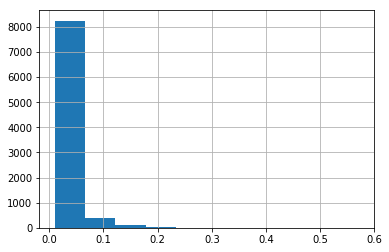

In [606]:
delivery_ext.score_percent.hist()

In [607]:
delivery_ext.score_percent.describe()

count    8836.000000
mean        0.027052
std         0.029596
min         0.010000
25%         0.012545
50%         0.017224
75%         0.028402
max         0.571311
Name: score_percent, dtype: float64

In [608]:
# 상대적 score 0.1이상인건, 3%정도밖에 안돼
delivery_ext[delivery_ext.score_percent >= 0.1].shape[0] / delivery_ext.shape[0]

0.03123585332729742

In [609]:
delivery_ext[delivery_ext.score_percent >= 0.1].shape # 276개

(276, 12)

In [ ]:
delvery_ext[delivery_ext.]

In [652]:
delivery.shape

(25113, 13)

In [653]:
delivery[delivery.score_percent >= 0.02].shape

(13605, 13)

In [654]:
delivery[delivery.score_percent >= 0.02].to_excel('./배송:비배송/delivery_cate_0418.xlsx')

---

- unique한 theme_id 20개로 살펴보자

In [656]:
cate_list = delivery[delivery.score_percent >= 0.02]['i'].unique()

In [657]:
len(cate_list)

1380

In [661]:
from random import sample

In [665]:
cate_list = cate_list.tolist()

In [666]:
sample(cate_list, 20)

[232060801,
 239030501,
 232070903,
 244020602,
 235010102,
 233050102,
 242020105,
 233110801,
 238010103,
 241010303,
 242030207,
 243020201,
 244010403,
 244010902,
 239020503,
 235020401,
 233060116,
 244010701,
 239021104,
 244020805]

In [676]:
sample(cate_list, 20)

[233070106,
 233100109,
 241010205,
 238020119,
 240010404,
 240040302,
 242010101,
 237050501,
 237060208,
 233030104,
 237050103,
 244030502,
 239021003,
 241030303,
 235060109,
 238050202,
 239020103,
 240010302,
 232050402,
 240040101]

In [692]:
sample(cate_list, 20)

[238070314,
 244010203,
 234010401,
 239010205,
 238060504,
 234030304,
 233110305,
 232063701,
 232062803,
 243020401,
 233020135,
 232040104,
 238020117,
 232061202,
 233100105,
 241030102,
 237060202,
 239021207,
 244010604,
 237020402]

In [693]:
sample(cate_list, 20)

[233050109,
 241010102,
 231010101,
 240040403,
 238070309,
 233030204,
 235010402,
 233050103,
 232020106,
 238060501,
 239020608,
 239010301,
 231050101,
 238030701,
 233070106,
 244010606,
 243030202,
 233110305,
 244030503,
 233110601]

In [667]:
result_df.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
0,0,237060101,237060101,0.373058,1.000000,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_롤화장지/물티슈/곽티슈,2,37,06,01,01
1,0,237060101,241020104,0.132828,0.356053,배송상품군_유아동/출산_물티슈_물티슈_물티슈 기타,2,41,02,01,04
2,0,237060101,241020107,0.029994,0.080401,배송상품군_유아동/출산_물티슈_물티슈_페넬로페,2,41,02,01,07
3,0,237060101,241010102,0.027745,0.074373,배송상품군_유아동/출산_기저귀/분유_기저귀_기저귀 기타,2,41,01,01,02
4,0,237060101,241020106,0.023269,0.062373,배송상품군_유아동/출산_물티슈_물티슈_순둥이,2,41,02,01,06


In [668]:
result_df[result_df.i == 235010504]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
23162,1298,235010504,235010504,0.162396,1.000000,배송상품군_브랜드패션_남성 정장_하의_스커트/치마,2,35,01,05,04
23163,1298,235010504,243030403,0.031303,0.192755,배송상품군_의류/소호_여성의류_하의_스커트/치마,2,43,03,04,03
23164,1298,235010504,235010105,0.016192,0.099704,배송상품군_브랜드패션_남성 정장_상의_원피스,2,35,01,01,05
23165,1298,235010504,243030107,0.015242,0.093859,배송상품군_의류/소호_여성의류_상의_원피스,2,43,03,01,07
23166,1298,235010504,243030401,0.013209,0.081339,배송상품군_의류/소호_여성의류_하의_바지/팬츠,2,43,03,04,01
23167,1298,235010504,235010501,0.012852,0.079141,배송상품군_브랜드패션_남성 정장_하의_바지/팬츠,2,35,01,05,01
23168,1298,235010504,235040404,0.009278,0.057130,배송상품군_브랜드패션_여성 캐주얼_하의_스커트/치마,2,35,04,04,04
23169,1298,235010504,235010106,0.009074,0.055876,배송상품군_브랜드패션_남성 정장_상의_자켓/코트,2,35,01,01,06
23170,1298,235010504,235010110,0.008898,0.054792,배송상품군_브랜드패션_남성 정장_상의_티셔츠,2,35,01,01,10
23171,1298,235010504,243030405,0.007811,0.048101,배송상품군_의류/소호_여성의류_하의_청바지/진,2,43,03,04,05


---

# <5월 3일> - 실제 적용

# # result_df_grp_new : 새로운 기준으로!
- <u>다른 카테고리면 상대점수가 0.1 이상 이어야한다!


In [78]:
len(result_df_grp)

1704

In [77]:
result_df_grp[0]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00


---

In [79]:
# 전체에서, depth4 or depth 5 가 다르면서도 상대적으로 score 규모가 5% 이상인것들 살펴보자
result_df_grp_new = {} # 이번에는 dict으로 받을게

for i,grp in enumerate(result_df_grp):
    
    # 상대 score 0.03이상,  같은 카테고리 내
    grp_tmp = grp[( grp[0:1].depth5.values[0] == grp.depth5 ) & ( grp[0:1].depth4.values[0] == grp.depth4)]
    
    #다른 카테고리에서, 상대 score가 0.1 이상이어서 보여지는것들
    concated_ = grp[((grp[0:1].depth5.values[0] != grp.depth5) | (grp[0:1].depth4.values[0] != grp.depth4)) 
                       & (grp.score_percent >= 0.1)]
    
    # 합쳐준다.
    result_df_grp_new[i] = pd.concat([grp_tmp, concated_], axis=0).sort_values(by='score_percent', ascending=False)

In [80]:
result_df_grp_new[998]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
544,118,237060702,237060702,0.268319,1.000000,배송상품군_생활/주방_화장지/세제_칫솔/면도/비누_비누,2,37,06,07,02
546,118,237060702,237030202,0.015603,0.058152,배송상품군_생활/주방_바디/헤어_바디케어_바디워시,2,37,03,02,02


In [82]:
result_df_grp_new[0]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00


In [83]:
result_df_grp_new[1]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
3281,542,101010200,101010200,0.128013,1.000000,서비스상품군_음식_한식_갈비/삼겹살_갈비/삼겹살,1,01,01,02,00
3282,542,101010200,101140100,0.005461,0.042656,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
3283,542,101010200,101150100,0.003848,0.030058,서비스상품군_음식_고기구이_샤브샤브_샤브샤브,1,01,15,01,00


---

---

### # 결과 합쳐주기

In [84]:
new_result_0503 = pd.DataFrame()

for i in range(len(result_df_grp_new)):
    new_result_0503 = pd.concat([new_result_0503, result_df_grp_new[i]], axis=0)


In [85]:
new_result_0503.shape

(8687, 11)

In [87]:
new_result_0503.head(5)

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00
3281,542,101010200,101010200,0.128013,1.000000,서비스상품군_음식_한식_갈비/삼겹살_갈비/삼겹살,1,01,01,02,00


---

- <u> 객체들 구분하기 쉽게 객체 number index 만들어주자 : "no"

In [89]:
no = []
for i,x in enumerate(new_result_0503['index']):
    #print(x)
    if i == 0:
        no.append(0)
    else:
        if new_result_0503['index'].values[i-1] != x: # 다르면 no를 하나 높여주고
            no.append(no[i-1]+1)
        else:
            no.append(no[i-1]) # 아니라면 no를 그대로 간다.

In [90]:
new_result_0503.shape

(8687, 11)

In [91]:
len(no)

8687

In [92]:
new_result_0503['index_no'] = no

In [93]:
new_result_0503.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00,0
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00,0
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00,0
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00,0
3281,542,101010200,101010200,0.128013,1.000000,서비스상품군_음식_한식_갈비/삼겹살_갈비/삼겹살,1,01,01,02,00,1


In [95]:
new_result_0503.to_excel('./new_result_0503.xlsx', encoding='utf-8-sig')

---

In [98]:
import matplotlib.pyplot as plt

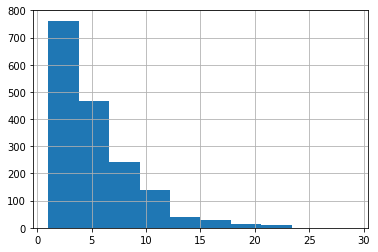

In [99]:
new_result_0503.groupby('index_no')['theme_names'].count().hist()

In [102]:
new_result_0503.groupby('index_no')['theme_names'].count().mean() # 평균적으로 5.09개

5.098004694835681

In [103]:
new_result_0503.groupby('index_no')['theme_names'].count().describe()

count    1704.000000
mean        5.098005
std         3.993435
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        29.000000
Name: theme_names, dtype: float64

### 정리
- 25%정도는 친구가 1명 이하야
- 친구가 1명~3명인 theme_id가 25%정도 존재해
- 친구가 3명~6명인 theme_id도 25%정도 존재해
- 친구가 가장 많은애는 34명 있어

In [762]:
xxx = new_result_0419.groupby('index_no')['theme_names'].count()

In [767]:
xxx.reset_index(drop=True, inplace=True)

In [774]:
xxx[xxx==1].shape[0]

224

In [772]:
xxx[xxx==1].shape[0]/xxx.shape[0] # 친구 없는애들이 약 13%

0.13776137761377613

In [775]:
xxx[xxx==2].shape[0]/xxx.shape[0]

0.13714637146371464

In [776]:
xxx[xxx==3].shape[0]/xxx.shape[0]

0.14391143911439114

In [773]:
xxx[xxx==1]

2       1
4       1
5       1
6       1
18      1
19      1
21      1
22      1
25      1
27      1
28      1
30      1
32      1
38      1
39      1
40      1
41      1
42      1
44      1
48      1
49      1
63      1
68      1
70      1
74      1
75      1
79      1
80      1
87      1
89      1
       ..
1275    1
1282    1
1284    1
1302    1
1307    1
1339    1
1353    1
1370    1
1421    1
1422    1
1474    1
1479    1
1494    1
1498    1
1537    1
1539    1
1562    1
1572    1
1574    1
1586    1
1590    1
1591    1
1596    1
1598    1
1609    1
1610    1
1614    1
1615    1
1616    1
1625    1
Name: theme_names, Length: 224, dtype: int64

In [780]:
xxx[xxx==1].index.tolist()

[2,
 4,
 5,
 6,
 18,
 19,
 21,
 22,
 25,
 27,
 28,
 30,
 32,
 38,
 39,
 40,
 41,
 42,
 44,
 48,
 49,
 63,
 68,
 70,
 74,
 75,
 79,
 80,
 87,
 89,
 93,
 99,
 107,
 108,
 112,
 118,
 121,
 123,
 126,
 127,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 139,
 144,
 186,
 194,
 201,
 232,
 248,
 265,
 272,
 275,
 277,
 292,
 313,
 325,
 332,
 341,
 343,
 344,
 347,
 349,
 351,
 359,
 363,
 367,
 371,
 373,
 383,
 386,
 389,
 403,
 416,
 418,
 449,
 450,
 466,
 508,
 523,
 533,
 544,
 550,
 556,
 558,
 561,
 568,
 570,
 584,
 588,
 602,
 606,
 626,
 630,
 639,
 693,
 710,
 721,
 724,
 725,
 729,
 730,
 731,
 732,
 733,
 738,
 746,
 748,
 751,
 753,
 756,
 767,
 768,
 772,
 775,
 776,
 779,
 780,
 783,
 784,
 787,
 791,
 797,
 812,
 813,
 814,
 819,
 823,
 843,
 845,
 848,
 859,
 878,
 880,
 900,
 952,
 955,
 962,
 965,
 982,
 984,
 994,
 1010,
 1012,
 1042,
 1053,
 1059,
 1060,
 1065,
 1072,
 1073,
 1077,
 1083,
 1084,
 1086,
 1092,
 1094,
 1097,
 1098,
 1099,
 1100,
 1104,
 1113,
 1118,
 1119,

In [783]:
no_friend = new_result_0419[new_result_0419.index_no.isin( xxx[xxx==1].index.tolist() )]

In [784]:
no_friend.to_excel('./새로 기준 결과/no_friend.xlsx')

In [761]:
new_result_0419.groupby('index_no')['theme_names'].count().shape

(1626,)

----

## cf. '배송상품군' / '비배송상품군' 구분해보자

In [104]:
new_result_0503.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00,0
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00,0
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00,0
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00,0
3281,542,101010200,101010200,0.128013,1.000000,서비스상품군_음식_한식_갈비/삼겹살_갈비/삼겹살,1,01,01,02,00,1


In [105]:
new_result_0503_grp = [grp[1] for grp in new_result_0503.groupby('index_no')]

In [107]:
len(new_result_0503_grp)

1704

In [108]:
# type으로 밝혀주기

for df in new_result_0503_grp:  ## 리스트다.
    if df.head(1).depth5.item() != '2':   # i 객체가 배송/비배송 인지 구분
        df['type'] = 'not delivery'
    else:
        df['type'] = 'delivery'

In [109]:
new_result_0503_grp[0]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no,type
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00,0,not delivery
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00,0,not delivery
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00,0,not delivery
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00,0,not delivery


In [110]:
## 저장
new_result_0503_ = pd.DataFrame()

for df in new_result_0503_grp:
    new_result_0503_ = pd.concat([new_result_0503_, df], axis=0 )

In [111]:
new_result_0503_.to_excel('./new_result_0503_type.xlsx')

---

## # step :  hirearchical clustering

In [112]:
new_result_0503_.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no,type
3100,521,101010100,101010100,0.125261,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00,0,not delivery
3101,521,101010100,101060100,0.005346,0.042682,서비스상품군_음식_양식_정통양식/경양식_정통양식/경양식,1,01,06,01,00,0,not delivery
3102,521,101010100,101140100,0.003990,0.031851,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00,0,not delivery
3103,521,101010100,101150200,0.003832,0.030594,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00,0,not delivery
3281,542,101010200,101010200,0.128013,1.000000,서비스상품군_음식_한식_갈비/삼겹살_갈비/삼겹살,1,01,01,02,00,1,not delivery


In [124]:
new_result_0503_.info() # j의 형태 바꿔주야겠다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8687 entries, 3100 to 10610
Data columns (total 13 columns):
index            8687 non-null int64
i                8687 non-null int64
j                8687 non-null object
score            8687 non-null float64
score_percent    8687 non-null float64
theme_names      8687 non-null object
depth5           8687 non-null object
depth4           8687 non-null object
depth3           8687 non-null object
depth2           8687 non-null object
depth1           8687 non-null object
index_no         8687 non-null int64
type             8687 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 950.1+ KB


In [126]:
new_result_0503_['j'] = new_result_0503_['j'].astype('int64')

In [127]:
df = new_result_0503_.drop(['index'], axis=1).copy()

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8687 entries, 3100 to 10610
Data columns (total 12 columns):
i                8687 non-null int64
j                8687 non-null int64
score            8687 non-null float64
score_percent    8687 non-null float64
theme_names      8687 non-null object
depth5           8687 non-null object
depth4           8687 non-null object
depth3           8687 non-null object
depth2           8687 non-null object
depth1           8687 non-null object
index_no         8687 non-null int64
type             8687 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 882.3+ KB


## 준비과정

scipy Sparse matrix 참고
https://lovit.github.io/nlp/machine%20learning/2018/04/09/sparse_mtarix_handling/


In [115]:
from scipy.sparse import csr_matrix, diags
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import ward, fcluster, dendrogram
import matplotlib.pyplot as plt

In [129]:
index_to_theme = {}
theme_to_index = {}
for th in set(df['j']):
    i = len(index_to_theme)
    index_to_theme[i] = th
    theme_to_index[th] = i

In [119]:
for th in set(df['j']):
    print(th)

233060124
235020106
232060703
240020205
234030301
238040103
233050108
244020507
240020103
243010106
301140000
234010501
233010207
231050203
232063801
242030208
242020101
103030800
239021006
233040125
232062101
233090309
232050901
232070607
232070901
244030401
231020201
233070108
237030205
101140600
232040109
241030302
244030901
239010202
235040108
232040105
231020101
240020102
239020608
106080100
232050904
239030305
243010203
402070000
237050603
238070312
241020102
235010101
231010403
244010506
244030102
235030104
302190000
244030601
231040301
240040104
243020101
233040108
232010201
244010806
237020701
233080120
232062205
238070308
235040304
233020107
238020108
244020205
302230000
231040101
240020108
238050306
232050703
232020102
237050102
239021102
239020303
239020308
103010300
106070200
232040102
240040404
244030402
233080108
235010403
237060104
106040800
234020304
244010607
302330000
235050104
231010202
233100112
244030205
101100400
242020102
239010704
238050201
232070401
239021203


In [130]:
len(index_to_theme)

1704

---
---

### JACCARD distance로 도전: 이후 다양한 metric으로 시도해보자

JACCARD distance로 시도한 이유



*  이미 biRank로 걸러진 i - j 간 관계는 경중을 같이 하여  중요한 것으로 취급한다.
*  discrete하게 바꿔서 노이즈에 강하게 한다.
* $J(A, B) = \frac{| A \cap B |}{|A \cup B|}$
* 예: $i \Rightarrow \{ 1,2,3,i\}, j \Rightarrow = \{ 1,2,j\}$
* $J(i,j) = \frac{2}{5}$



In [131]:
theme_to_names = {}
names_to_theme = {}
rows, cols, vals = [], [], []
for _, row in df.iterrows():
    i,j,score,theme_names = row['i'], row['j'], row['score'], row['theme_names']
    if j not in theme_to_names:
        theme_to_names[j] = theme_names
        names_to_theme[theme_names] = j
    rows.append(theme_to_index[i])
    cols.append(theme_to_index[j])
    vals.append(1.0)     # jaccard를 metric으로 쓰기 위해서는 1.0으로 값을 설정
  #vals.append(score)

In [132]:
# Sparse Matrix (T=1626, T=1626)
W = csr_matrix((vals, (rows, cols)), dtype=np.float)

In [159]:
W.shape

(1704, 1704)

In [133]:
Y = pdist(W.todense(), metric='jaccard') ## W.todense() 는 행렬로 바꿔준다는거야! / pdist : pairwise - distance

---

- 뜯어보기

In [167]:
W.todense().shape

(1704, 1704)

In [168]:
W.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [160]:
Y

array([1., 1., 1., ..., 1., 1., 1.])

In [174]:
852*1703 # combinations(1704, 2)

1450956

In [158]:
Y.shape

(1450956,)

In [175]:
Y.max()

1.0

---

In [2]:
%pwd

'/Users/we/Downloads/GCS data/19년 3월/keyword/실장님 ver/birank/0503'

In [134]:
# 널리 쓰이는 WARD 기법을 사용 - linkage matrix 를 만드는거야.
Z = ward(Y)

In [177]:
Z.shape

(1703, 4)

In [178]:
Z

array([[2.97000000e+02, 1.27500000e+03, 0.00000000e+00, 2.00000000e+00],
       [6.00000000e+00, 5.45000000e+02, 0.00000000e+00, 2.00000000e+00],
       [9.00000000e+02, 9.04000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [2.74200000e+03, 3.40300000e+03, 3.40139771e+00, 1.65800000e+03],
       [3.09600000e+03, 3.40400000e+03, 3.46582333e+00, 1.67200000e+03],
       [3.33900000e+03, 3.40500000e+03, 3.79227797e+00, 1.70400000e+03]])

덴드로그램 PLOT

In [135]:
# labes 구성
labels = []
for i in range(len(index_to_theme)):
    labels.append("{}".format(index_to_theme[i]))

In [182]:
#dn = dendrogram(Z, orientation='right', show_contracted=True, show_leaf_counts=True, labels=labels)
#fig = plt.gcf()
#fig.set_size_inches(50,200)
#plt.show()

다양한 criterion으로 시도해보자

In [136]:
# 단순하게 distance를 사용해 봄
ii = fcluster(Z, t=0.8, criterion='distance')

그룹화

In [137]:
groups = {}
for i,c in enumerate(ii):
    th = index_to_theme[i]
    nm = theme_to_names[th]
    if c not in groups:    
        groups[c] = [(th, nm)]
    else:
        groups[c].append((th, nm))

부가 조사

*   가장 큰 그룹의 크기
*   두개이상 할당된 그룹의 갯수 등등



In [138]:
counts = {}
cnt = 0
for c in ii:
    cnt += 1
    if c not in counts:
        counts[c] = 1
    else:
        counts[c] += 1

from operator import itemgetter, attrgetter
sorted_cnt = sorted(counts.items(), key=itemgetter(1), reverse=True)

In [139]:
effective_cnt = 0
total_effective_cnt = 0
for c, cnt in counts.items():
    if cnt >= 2:
        effective_cnt += 1
        total_effective_cnt += cnt

In [140]:
print("# of themes = {}".format(len(theme_to_index)))
print("# of groups = {}".format(len(sorted_cnt)))
print("# max-cluster size = {}".format(sorted_cnt[0][1]))
print("# of groups with its size greater than or equal to two = {}".format(effective_cnt))
print("# of themes assigned into those groups = {}".format(total_effective_cnt))

# of themes = 1704
# of groups = 791
# max-cluster size = 12
# of groups with its size greater than or equal to two = 420
# of themes assigned into those groups = 1333


---

In [211]:
# 단순하게 distance를 사용해 봄
ii = fcluster(Z, t=0.95, criterion='distance')

그룹화

In [212]:
groups = {}
for i,c in enumerate(ii):
    th = index_to_theme[i]
    nm = theme_to_names[th]
    if c not in groups:    
        groups[c] = [(th, nm)]
    else:
        groups[c].append((th, nm))

부가 조사

*   가장 큰 그룹의 크기
*   두개이상 할당된 그룹의 갯수 등등



In [213]:
counts = {}
cnt = 0
for c in ii:
    cnt += 1
    if c not in counts:
        counts[c] = 1
    else:
        counts[c] += 1

from operator import itemgetter, attrgetter
sorted_cnt = sorted(counts.items(), key=itemgetter(1), reverse=True)

In [214]:
effective_cnt = 0
total_effective_cnt = 0
for c, cnt in counts.items():
    if cnt >= 2:
        effective_cnt += 1
        total_effective_cnt += cnt

In [215]:
print("# of themes = {}".format(len(theme_to_index)))
print("# of groups = {}".format(len(sorted_cnt)))
print("# max-cluster size = {}".format(sorted_cnt[0][1]))
print("# of groups with its size greater than or equal to two = {}".format(effective_cnt))
print("# of themes assigned into those groups = {}".format(total_effective_cnt))

# of themes = 1704
# of groups = 698
# max-cluster size = 12
# of groups with its size greater than or equal to two = 380
# of themes assigned into those groups = 1386


In [194]:
394/727

0.5419532324621733

In [195]:
420/791

0.5309734513274337

In [210]:
384/706

0.5439093484419264

In [216]:
380/698

0.5444126074498568

In [217]:
# csv 생성
vec_g = []
vec_th = []
vec_nm = []
for g, cnt in sorted_cnt:
    for th, nm in groups[g]:
        vec_g.append(g)
        vec_th.append(th)
        vec_nm.append(nm)

result_df = pd.DataFrame.from_dict({'group':vec_g, 'theme':vec_th, 'theme_names':vec_nm})

In [218]:
no = []
for i,x in enumerate(result_df['group']):
    #print(x)
    if i == 0:
        no.append(0)
    else:
        if result_df['group'].values[i-1] != x: # 다르면 no를 하나 높여주고
            no.append(no[i-1]+1)
        else:
            no.append(no[i-1]) # 아니라면 no를 그대로 간다.

In [219]:
result_df['no'] = no

In [220]:
result_df.head(20)

,group,theme,theme_names,no
0,9,244010601,배송상품군_잡화_국내브랜드_쥬얼리_귀걸이,0
1,9,244010602,배송상품군_잡화_국내브랜드_쥬얼리_목걸이/팬던트,0
2,9,244010603,배송상품군_잡화_국내브랜드_쥬얼리_반지,0
3,9,244010604,배송상품군_잡화_국내브랜드_쥬얼리_순금/골드바/돌반지,0
4,9,244010605,배송상품군_잡화_국내브랜드_쥬얼리_쥬얼리세트,0
5,9,244010607,배송상품군_잡화_국내브랜드_쥬얼리_팔찌/발찌,0
6,9,244030601,배송상품군_잡화_트랜드_쥬얼리_귀걸이,0
7,9,244030602,배송상품군_잡화_트랜드_쥬얼리_목걸이/팬던트,0
8,9,244030603,배송상품군_잡화_트랜드_쥬얼리_반지,0
9,9,244030604,배송상품군_잡화_트랜드_쥬얼리_순금/골드바/돌반지,0


In [222]:
result_df.to_excel("0507_grouping_categories_fin.xlsx", encoding='utf-8-sig')

## 출력

In [0]:
#result_df.to_csv("gdrive/My Drive/data/grouping_categories_from_mklee_0406.csv")

---

In [141]:
# csv 생성
vec_g = []
vec_th = []
vec_nm = []
for g, cnt in sorted_cnt:
    for th, nm in groups[g]:
        vec_g.append(g)
        vec_th.append(th)
        vec_nm.append(nm)

result_df = pd.DataFrame.from_dict({'group':vec_g, 'theme':vec_th, 'theme_names':vec_nm})

---

- result_df 심심하다 : 조금 더 만들어주자 - (*) index

In [149]:
result_df.head(20)

,group,theme,theme_names
0,11,244010601,배송상품군_잡화_국내브랜드_쥬얼리_귀걸이
1,11,244010602,배송상품군_잡화_국내브랜드_쥬얼리_목걸이/팬던트
2,11,244010603,배송상품군_잡화_국내브랜드_쥬얼리_반지
3,11,244010604,배송상품군_잡화_국내브랜드_쥬얼리_순금/골드바/돌반지
4,11,244010605,배송상품군_잡화_국내브랜드_쥬얼리_쥬얼리세트
5,11,244010607,배송상품군_잡화_국내브랜드_쥬얼리_팔찌/발찌
6,11,244030601,배송상품군_잡화_트랜드_쥬얼리_귀걸이
7,11,244030602,배송상품군_잡화_트랜드_쥬얼리_목걸이/팬던트
8,11,244030603,배송상품군_잡화_트랜드_쥬얼리_반지
9,11,244030604,배송상품군_잡화_트랜드_쥬얼리_순금/골드바/돌반지


In [151]:
no = []
for i,x in enumerate(result_df['group']):
    #print(x)
    if i == 0:
        no.append(0)
    else:
        if result_df['group'].values[i-1] != x: # 다르면 no를 하나 높여주고
            no.append(no[i-1]+1)
        else:
            no.append(no[i-1]) # 아니라면 no를 그대로 간다.

In [152]:
no

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 26,
 26,
 26,
 27,
 27,
 27,
 27,
 27,
 27,
 28,
 28,
 28,
 28,
 28,
 28,
 29,
 29,
 29,

In [153]:
result_df['no'] = no

In [155]:
result_df.head(20)

,group,theme,theme_names,no
0,11,244010601,배송상품군_잡화_국내브랜드_쥬얼리_귀걸이,0
1,11,244010602,배송상품군_잡화_국내브랜드_쥬얼리_목걸이/팬던트,0
2,11,244010603,배송상품군_잡화_국내브랜드_쥬얼리_반지,0
3,11,244010604,배송상품군_잡화_국내브랜드_쥬얼리_순금/골드바/돌반지,0
4,11,244010605,배송상품군_잡화_국내브랜드_쥬얼리_쥬얼리세트,0
5,11,244010607,배송상품군_잡화_국내브랜드_쥬얼리_팔찌/발찌,0
6,11,244030601,배송상품군_잡화_트랜드_쥬얼리_귀걸이,0
7,11,244030602,배송상품군_잡화_트랜드_쥬얼리_목걸이/팬던트,0
8,11,244030603,배송상품군_잡화_트랜드_쥬얼리_반지,0
9,11,244030604,배송상품군_잡화_트랜드_쥬얼리_순금/골드바/돌반지,0


In [156]:
result_df.to_csv("0503_grouping_categories_fin.csv", encoding='utf-8-sig')

## ------------------------------------------------------------0503 마무리

---

# # 0423 

In [792]:
new_result_0419_.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no,type
2854,490,101010100,101010100,0.123840,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00,0,not delivery
2855,490,101010100,101030500,0.008259,0.066692,서비스상품군_음식_일식/수산물_해물찜/탕전문_해물찜/탕전문,1,01,03,05,00,0,not delivery
2856,490,101010100,101140100,0.006056,0.048903,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00,0,not delivery
2857,490,101010100,101030400,0.004493,0.036285,서비스상품군_음식_일식/수산물_참치전문점_참치전문점,1,01,03,04,00,0,not delivery
2858,490,101010100,101040300,0.004422,0.035711,서비스상품군_음식_분식_떡볶이전문_떡볶이전문,1,01,04,03,00,0,not delivery


In [793]:
new_result_0419_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8331 entries, 2854 to 4924
Data columns (total 13 columns):
index            8331 non-null int64
i                8331 non-null int64
j                8331 non-null object
score            8331 non-null float64
score_percent    8331 non-null float64
theme_names      8331 non-null object
depth5           8331 non-null object
depth4           8331 non-null object
depth3           8331 non-null object
depth2           8331 non-null object
depth1           8331 non-null object
index_no         8331 non-null int64
type             8331 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 911.2+ KB


In [796]:
new_0423 = new_result_0419_[['j', 'index_no']].copy()

In [797]:
new_0423.head()

,j,index_no
2854,101010100,0
2855,101030500,0
2856,101140100,0
2857,101030400,0
2858,101040300,0


In [799]:
new_0423['j'] = new_0423.j.astype('int64')

In [800]:
new_0423.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8331 entries, 2854 to 4924
Data columns (total 2 columns):
j           8331 non-null int64
index_no    8331 non-null int64
dtypes: int64(2)
memory usage: 195.3 KB


In [804]:
new_0423.j.nunique()

1626

In [803]:
new_0423[new_0423.j == 101010100]

,j,index_no
2854,101010100,0
8558,101010100,16
150,101010100,24


* 할 일 : <u> 1626개의 feature갖는 matrix 구성해서, clustering 해보자!

##### ------------------------0423 마무리 ---------------------------------

----

In [514]:
len(result_df_grp)

1626

In [541]:
not_delivery = pd.DataFrame()
for df in result_df_grp:  ## 리스트다.
    if df.head(1).depth5.item() != '2':
        not_delivery = pd.concat([not_delivery, df], axis=0)

In [542]:
not_delivery.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
7966,490,101010100,101010100,0.123840,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
7967,490,101010100,101030500,0.008259,0.066692,서비스상품군_음식_일식/수산물_해물찜/탕전문_해물찜/탕전문,1,01,03,05,00
7968,490,101010100,101140100,0.006056,0.048903,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
7969,490,101010100,101030400,0.004493,0.036285,서비스상품군_음식_일식/수산물_참치전문점_참치전문점,1,01,03,04,00
7970,490,101010100,101040300,0.004422,0.035711,서비스상품군_음식_분식_떡볶이전문_떡볶이전문,1,01,04,03,00


In [531]:
result_df.shape

(27948, 11)

In [543]:
not_delivery.shape # 

(2835, 11)

In [545]:
# 다른 객체들 구분 할 수 있는 '숫자' 만들어주기

no = []
for i,x in enumerate(not_delivery['index']):
    #print(x)
    if i == 0:
        no.append(0)
    else:
        if not_delivery['index'].values[i-1] != x:
            no.append(no[i-1]+1)
        else:
            no.append(no[i-1])

In [546]:
len(no)

2835

In [547]:
not_delivery['index_no'] = no

In [548]:
not_delivery.head()

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1,index_no
7966,490,101010100,101010100,0.123840,1.000000,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00,0
7967,490,101010100,101030500,0.008259,0.066692,서비스상품군_음식_일식/수산물_해물찜/탕전문_해물찜/탕전문,1,01,03,05,00,0
7968,490,101010100,101140100,0.006056,0.048903,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00,0
7969,490,101010100,101030400,0.004493,0.036285,서비스상품군_음식_일식/수산물_참치전문점_참치전문점,1,01,03,04,00,0
7970,490,101010100,101040300,0.004422,0.035711,서비스상품군_음식_분식_떡볶이전문_떡볶이전문,1,01,04,03,00,0


#### ---------------- 4월 19일 마무리 ----------------

---

## cf. 자기 자신 score도 한번 살펴보자

In [507]:
tmp_t = pd.DataFrame()

for i in range(result_df.shape[0]):
    
    if result_df[i:i+1]['i'].item() == int(result_df[i:i+1]['j'].item()) :
        tmp_t = pd.concat([tmp_t, result_df[i:i+1].copy()], axis=0)

In [508]:
tmp_t

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
0,0,237060101,237060101,0.373058,1.0,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_롤화장지/물티슈/곽티슈,2,37,06,01,01
11,1,237060102,237060102,0.157604,1.0,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_방향제,2,37,06,01,02
25,2,237060103,237060103,0.338799,1.0,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_살충제,2,37,06,01,03
31,3,237060104,237060104,0.294804,1.0,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_제습제/제설제,2,37,06,01,04
38,4,237060105,237060105,0.211598,1.0,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_탈취제,2,37,06,01,05
57,5,235020304,235020304,0.125418,1.0,배송상품군_브랜드패션_남성 캐주얼_테마의류_트레이닝복,2,35,02,03,04
59,6,232063002,232063002,0.102119,1.0,배송상품군_도서/교육_일반도서_인테리어/살림상식_인테리어/살림상식,2,32,06,30,02
61,7,232071206,232071206,0.208488,1.0,배송상품군_도서/교육_학습/수험서_초등학교_초등학교 과목별,2,32,07,12,06
95,8,232071207,232071207,0.122881,1.0,배송상품군_도서/교육_학습/수험서_초등학교_초등학교 기타,2,32,07,12,07
101,9,232071208,232071208,0.110287,1.0,배송상품군_도서/교육_학습/수험서_초등학교_학습/공부법/사전,2,32,07,12,08


In [511]:
tmp_t.sort_values(by='score', ascending=False)

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
1320,108,232063603,232063603,0.526283,1.0,배송상품군_도서/교육_일반도서_투자/재테크_주식/증권/펀드,2,32,06,36,03
822,67,233030104,233030104,0.526283,1.0,배송상품군_디지털/가전_노트북/데스크탑_노트북_노트북 33cm,2,33,03,01,04
26355,1506,232070408,232070408,0.526283,1.0,배송상품군_도서/교육_학습/수험서_대학교재_사회과학계열,2,32,07,04,08
18503,1103,501020000,501020000,0.498883,1.0,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00
18691,1117,238040501,238040501,0.485585,1.0,배송상품군_스포츠/자동차_블랙박스/네비게이션_하이패스_하이패스/GPS,2,38,04,05,01
14611,873,240030103,240030103,0.442103,1.0,배송상품군_식품/건강_신선식품_과실류_과일,2,40,03,01,03
3605,237,233080107,233080107,0.435513,1.0,배송상품군_디지털/가전_주방가전_주방가전_식품건조기,2,33,08,01,07
27848,1619,302170000,302170000,0.433346,1.0,여행상품군_해외_대마도_대마도_대마도,3,02,17,00,00
27414,1588,232070901,232070901,0.430293,1.0,배송상품군_도서/교육_학습/수험서_자격증_공인중개/주택관리사,2,32,07,09,01
22110,1256,240040102,240040102,0.429231,1.0,배송상품군_식품/건강_커피/음료_생수/음료_생수/탄산수,2,40,04,01,02


In [510]:
tmp_t.score.describe()

count    1626.000000
mean        0.181000
std         0.074551
min         0.100092
25%         0.122322
50%         0.157453
75%         0.220466
max         0.526283
Name: score, dtype: float64

---

## cf.

In [423]:
len(ext_index)

535

In [425]:
result_df[result_df['index'] == 1446]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
25556,1446,232062005,232062005,0.108590,1.000000,배송상품군_도서/교육_일반도서_여행_해외여행,2,32,06,20,05
25557,1446,232062005,302280000,0.009438,0.086918,여행상품군_해외_하와이_하와이_하와이,3,02,28,00,00
25558,1446,232062005,302130000,0.008895,0.081917,여행상품군_해외_동남아기타_동남아기타_동남아기타,3,02,13,00,00
25559,1446,232062005,302190000,0.005888,0.054218,여행상품군_해외_일본기타_일본기타_일본기타,3,02,19,00,00
25560,1446,232062005,302100000,0.004632,0.042659,여행상품군_해외_방콕/파타야_방콕/파타야_방콕/파타야,3,02,10,00,00
25561,1446,232062005,302240000,0.004250,0.039135,여행상품군_해외_대만_대만_대만,3,02,24,00,00
25562,1446,232062005,302010000,0.003902,0.035935,여행상품군_해외_괌_괌_괌,3,02,01,00,00
25563,1446,232062005,302270000,0.003720,0.034253,여행상품군_해외_유럽_유럽_유럽,3,02,27,00,00
25564,1446,232062005,232050801,0.003285,0.030248,배송상품군_도서/교육_유아동도서_중고도서_중고도서 기타,2,32,05,08,01
25565,1446,232062005,302160000,0.002811,0.025888,여행상품군_해외_오사카_오사카_오사카,3,02,16,00,00


In [419]:
sum_ = 0
ext_index = []
for i,df in result_df_grp_test.items():
    if df.shape[0] > 1:
        sum_ += df.shape[0]
        print(i)
        ext_index.append(i) # 예외 index 저장

9
11
22
35
44
47
48
50
54
66
68
69
71
72
73
75
77
81
83
89
90
91
92
94
95
96
97
101
102
103
110
111
113
114
115
117
122
123
124
125
126
128
132
136
137
140
142
143
157
158
159
162
163
164
167
168
169
170
175
176
185
188
192
193
195
196
198
199
200
202
215
220
222
224
236
239
240
241
250
253
263
266
267
268
272
275
287
289
297
303
315
317
318
326
328
329
345
346
347
352
359
364
374
377
379
384
395
399
401
402
413
414
419
420
424
425
426
428
429
430
431
436
449
459
462
480
494
501
519
524
526
528
530
532
535
537
538
540
557
562
566
571
575
577
582
587
589
601
603
616
621
639
640
642
645
646
649
653
654
656
657
658
659
661
662
663
664
669
670
677
678
679
686
687
688
689
692
693
694
696
703
704
705
706
707
708
709
711
712
713
714
715
716
717
719
720
743
749
750
752
764
765
785
786
788
789
790
793
794
796
797
799
801
802
803
804
806
807
809
813
818
820
823
824
826
828
829
836
837
838
839
840
844
846
855
857
859
861
864
866
867
871
875
877
878
879
884
885
887
888
890
891
892
898
901
902
904


In [331]:
sum_

1092

In [332]:
ext_index[0]

9

In [333]:
result_df_grp[ext_index[0]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15609,925,101012100,101012100,0.107578,1.000000,서비스상품군_음식_한식_기타고기요리_기타고기요리,1,01,01,21,00
15610,925,101012100,501020000,0.016383,0.152291,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00
15611,925,101012100,101110100,0.003396,0.031568,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00
15612,925,101012100,301140000,0.001425,0.013242,여행상품군_국내_기타_기타_기타,3,01,14,00,00
15613,925,101012100,103010800,0.001112,0.010340,서비스상품군_생활서비스_이/미용/건강_마사지_마사지,1,03,01,08,00


---

### - result :  ext_index[0]

In [334]:
result_df_grp_test[ext_index[0]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15610,925,101012100,501020000,0.016383,0.152291,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00


In [343]:
result_df_grp_[ext_index[0]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15609,925,101012100,101012100,0.107578,1.000000,서비스상품군_음식_한식_기타고기요리_기타고기요리,1,01,01,21,00
15611,925,101012100,101110100,0.003396,0.031568,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00


---

### - result :  ext_index[1]

In [335]:
result_df_grp[ext_index[1]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15472,913,101020200,101020200,0.130989,1.000000,서비스상품군_음식_중식_탕수육전문점_탕수육전문점,1,01,02,02,00
15473,913,101020200,407010000,0.011473,0.087584,공연상품군_전시_미술_미술_미술,4,07,01,00,00
15474,913,101020200,101031000,0.007328,0.055943,서비스상품군_음식_일식/수산물_바닷가재/게요리전문_바닷가재/게요리전문,1,01,03,10,00
15475,913,101020200,407030000,0.002385,0.018208,공연상품군_전시_기타_기타_기타,4,07,03,00,00


In [336]:
result_df_grp_test[ext_index[1]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15473,913,101020200,407010000,0.011473,0.087584,공연상품군_전시_미술_미술_미술,4,07,01,00,00


In [344]:
result_df_grp_[ext_index[1]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15472,913,101020200,101020200,0.130989,1.000000,서비스상품군_음식_중식_탕수육전문점_탕수육전문점,1,01,02,02,00
15474,913,101020200,101031000,0.007328,0.055943,서비스상품군_음식_일식/수산물_바닷가재/게요리전문_바닷가재/게요리전문,1,01,03,10,00


---

### - result :  ext_index[2]

In [337]:
result_df_grp[ext_index[2]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
26393,1510,101031200,101031200,0.119583,1.000000,서비스상품군_음식_일식/수산물_낙지/오징어_낙지/오징어,1,01,03,12,00
26394,1510,101031200,407010000,0.007777,0.065032,공연상품군_전시_미술_미술_미술,4,07,01,00,00
26395,1510,101031200,407030000,0.001638,0.013694,공연상품군_전시_기타_기타_기타,4,07,03,00,00
26396,1510,101031200,301130000,0.001291,0.010794,여행상품군_국내_체혐_체혐_체혐,3,01,13,00,00


In [338]:
result_df_grp_test[ext_index[2]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
26394,1510,101031200,407010000,0.007777,0.065032,공연상품군_전시_미술_미술_미술,4,07,01,00,00


In [345]:
result_df_grp_[ext_index[2]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
26393,1510,101031200,101031200,0.119583,1.0,서비스상품군_음식_일식/수산물_낙지/오징어_낙지/오징어,1,01,03,12,00


---

### - result :  ext_index[3]

In [346]:
result_df_grp[ext_index[3]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12576,754,101060500,101060500,0.112261,1.000000,서비스상품군_음식_양식_패밀리레스토랑_패밀리레스토랑,1,01,06,05,00
12577,754,101060500,106030700,0.006924,0.061677,서비스상품군_관광/여가/오락_연극/영화/극장_영화관_영화관,1,06,03,07,00
12578,754,101060500,101030500,0.005219,0.046489,서비스상품군_음식_일식/수산물_해물찜/탕전문_해물찜/탕전문,1,01,03,05,00
12579,754,101060500,101010100,0.002964,0.026404,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
12580,754,101060500,404010000,0.002950,0.026274,공연상품군_클래식_클래식_클래식_클래식,4,04,01,00,00
12581,754,101060500,501010000,0.002837,0.025275,온라인상품군_이용권_온라인 이용권_온라인 이용권_온라인 이용권,5,01,01,00,00
12582,754,101060500,103010200,0.002186,0.019471,서비스상품군_생활서비스_이/미용/건강_발/네일케어_발/네일케어,1,03,01,02,00
12583,754,101060500,106070100,0.002172,0.019352,서비스상품군_관광/여가/오락_놀이/여가/취미_종합위락시설_종합위락시설,1,06,07,01,00
12584,754,101060500,101030400,0.002093,0.018644,서비스상품군_음식_일식/수산물_참치전문점_참치전문점,1,01,03,04,00
12585,754,101060500,101050100,0.002053,0.018284,서비스상품군_음식_닭/오리요리_삼계탕전문_삼계탕전문,1,01,05,01,00


In [347]:
result_df_grp_test[ext_index[3]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12577,754,101060500,106030700,0.006924,0.061677,서비스상품군_관광/여가/오락_연극/영화/극장_영화관_영화관,1,06,03,07,00


In [348]:
result_df_grp_[ext_index[3]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12576,754,101060500,101060500,0.112261,1.000000,서비스상품군_음식_양식_패밀리레스토랑_패밀리레스토랑,1,01,06,05,00
12578,754,101060500,101030500,0.005219,0.046489,서비스상품군_음식_일식/수산물_해물찜/탕전문_해물찜/탕전문,1,01,03,05,00
12579,754,101060500,101010100,0.002964,0.026404,서비스상품군_음식_한식_한식/백반/한정식_한식/백반/한정식,1,01,01,01,00
12584,754,101060500,101030400,0.002093,0.018644,서비스상품군_음식_일식/수산물_참치전문점_참치전문점,1,01,03,04,00
12585,754,101060500,101050100,0.002053,0.018284,서비스상품군_음식_닭/오리요리_삼계탕전문_삼계탕전문,1,01,05,01,00
12586,754,101060500,101080100,0.002027,0.018054,서비스상품군_음식_제과제빵떡케익_제과점_제과점,1,01,08,01,00


---

### - result :  ext_index[4]

In [349]:
result_df_grp[ext_index[4]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
2436,169,101090300,101090300,0.105908,1.000000,서비스상품군_음식_유흥주점_꼬치구이전문점_꼬치구이전문점,1,01,09,03,00
2437,169,101090300,240030607,0.006252,0.059037,배송상품군_식품/건강_신선식품_축산_오리고기/기타육류,2,40,03,06,07
2438,169,101090300,101020100,0.002618,0.024721,서비스상품군_음식_중식_중국음식/중국집_중국음식/중국집,1,01,02,01,00
2439,169,101090300,240030601,0.001282,0.012104,배송상품군_식품/건강_신선식품_축산_가공육/양념육류,2,40,03,06,01


In [350]:
result_df_grp_test[ext_index[4]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
2437,169,101090300,240030607,0.006252,0.059037,배송상품군_식품/건강_신선식품_축산_오리고기/기타육류,2,40,03,06,07


In [351]:
result_df_grp_[ext_index[4]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
2436,169,101090300,101090300,0.105908,1.000000,서비스상품군_음식_유흥주점_꼬치구이전문점_꼬치구이전문점,1,01,09,03,00
2438,169,101090300,101020100,0.002618,0.024721,서비스상품군_음식_중식_중국음식/중국집_중국음식/중국집,1,01,02,01,00


---

### - result :  ext_index[5]

In [352]:
result_df_grp[ext_index[5]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
14328,852,101110100,101110100,0.134899,1.000000,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00
14329,852,101110100,103010800,0.031805,0.235770,서비스상품군_생활서비스_이/미용/건강_마사지_마사지,1,03,01,08,00
14330,852,101110100,106071000,0.014670,0.108751,서비스상품군_관광/여가/오락_놀이/여가/취미_기타오락관련산업_기타오락관련산업,1,06,07,10,00
14331,852,101110100,103070400,0.014549,0.107849,서비스상품군_생활서비스_물품기기대여_도서/만화대여_도서/만화대여,1,03,07,04,00
14332,852,101110100,101110400,0.011542,0.085563,서비스상품군_음식_다방/커피숍/카페_보드게임카페_보드게임카페,1,01,11,04,00
14333,852,101110100,103010300,0.010760,0.079763,서비스상품군_생활서비스_이/미용/건강_비만/피부관리_비만/피부관리,1,03,01,03,00
14334,852,101110100,501020000,0.008387,0.062175,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00
14335,852,101110100,101110200,0.007278,0.053953,서비스상품군_음식_다방/커피숍/카페_커피전문점_커피전문점,1,01,11,02,00
14336,852,101110100,106070100,0.006206,0.046005,서비스상품군_관광/여가/오락_놀이/여가/취미_종합위락시설_종합위락시설,1,06,07,01,00
14337,852,101110100,106020100,0.005119,0.037950,서비스상품군_관광/여가/오락_무도/유흥/가무_노래방/멀티방_노래방/멀티방,1,06,02,01,00


In [353]:
result_df_grp_test[ext_index[5]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
14329,852,101110100,103010800,0.031805,0.235770,서비스상품군_생활서비스_이/미용/건강_마사지_마사지,1,03,01,08,00
14330,852,101110100,106071000,0.014670,0.108751,서비스상품군_관광/여가/오락_놀이/여가/취미_기타오락관련산업_기타오락관련산업,1,06,07,10,00
14331,852,101110100,103070400,0.014549,0.107849,서비스상품군_생활서비스_물품기기대여_도서/만화대여_도서/만화대여,1,03,07,04,00
14333,852,101110100,103010300,0.010760,0.079763,서비스상품군_생활서비스_이/미용/건강_비만/피부관리_비만/피부관리,1,03,01,03,00
14334,852,101110100,501020000,0.008387,0.062175,온라인상품군_이용권_생활쿠폰_생활쿠폰_생활쿠폰,5,01,02,00,00


In [354]:
result_df_grp_[ext_index[5]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
14328,852,101110100,101110100,0.134899,1.000000,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00
14332,852,101110100,101110400,0.011542,0.085563,서비스상품군_음식_다방/커피숍/카페_보드게임카페_보드게임카페,1,01,11,04,00
14335,852,101110100,101110200,0.007278,0.053953,서비스상품군_음식_다방/커피숍/카페_커피전문점_커피전문점,1,01,11,02,00
14339,852,101110100,101140100,0.003632,0.026923,서비스상품군_음식_부페_종합부페_종합부페,1,01,14,01,00
14342,852,101110100,101012100,0.003377,0.025031,서비스상품군_음식_한식_기타고기요리_기타고기요리,1,01,01,21,00
14346,852,101110100,101110700,0.002856,0.021172,서비스상품군_음식_다방/커피숍/카페_애견카페_애견카페,1,01,11,07,00
14356,852,101110100,101060600,0.001722,0.012765,서비스상품군_음식_양식_바베큐전문_바베큐전문,1,01,06,06,00
14357,852,101110100,101150200,0.001660,0.012305,서비스상품군_음식_고기구이_돼지고기_돼지고기,1,01,15,02,00
14360,852,101110100,101030300,0.001574,0.011671,서비스상품군_음식_일식/수산물_음식점-초밥전문_음식점-초밥전문,1,01,03,03,00
14361,852,101110100,101140500,0.001510,0.011197,서비스상품군_음식_부페_해물부페_해물부페,1,01,14,05,00


---

### - result :  ext_index[6]

In [355]:
result_df_grp[ext_index[6]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15009,888,101110200,101110200,0.283658,1.000000,서비스상품군_음식_다방/커피숍/카페_커피전문점_커피전문점,1,01,11,02,00
15010,888,101110200,232063901,0.015617,0.055057,배송상품군_도서/교육_일반도서_학습_경제/자기계발,2,32,06,39,01
15011,888,101110200,101110100,0.007295,0.025716,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00


In [356]:
result_df_grp_test[ext_index[6]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15010,888,101110200,232063901,0.015617,0.055057,배송상품군_도서/교육_일반도서_학습_경제/자기계발,2,32,06,39,01


In [357]:
result_df_grp_[ext_index[6]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
15009,888,101110200,101110200,0.283658,1.000000,서비스상품군_음식_다방/커피숍/카페_커피전문점_커피전문점,1,01,11,02,00
15011,888,101110200,101110100,0.007295,0.025716,서비스상품군_음식_다방/커피숍/카페_다방/커피숍/카페_다방/커피숍/카페,1,01,11,01,00


---

In [358]:
ext_index

[9,
 11,
 22,
 35,
 44,
 47,
 48,
 50,
 54,
 66,
 68,
 69,
 71,
 72,
 73,
 75,
 77,
 81,
 83,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 101,
 102,
 103,
 110,
 111,
 113,
 114,
 115,
 117,
 122,
 123,
 124,
 125,
 126,
 128,
 132,
 136,
 137,
 140,
 142,
 143,
 157,
 158,
 159,
 162,
 163,
 164,
 167,
 168,
 169,
 170,
 175,
 176,
 185,
 188,
 192,
 193,
 195,
 196,
 198,
 199,
 200,
 202,
 215,
 220,
 222,
 224,
 236,
 239,
 240,
 241,
 250,
 253,
 263,
 266,
 267,
 268,
 272,
 275,
 287,
 289,
 297,
 303,
 315,
 317,
 318,
 326,
 328,
 329,
 345,
 346,
 347,
 352,
 359,
 364,
 374,
 377,
 379,
 384,
 395,
 399,
 401,
 402,
 413,
 414,
 419,
 420,
 424,
 425,
 426,
 428,
 429,
 430,
 431,
 436,
 449,
 459,
 462,
 480,
 494,
 501,
 519,
 524,
 526,
 528,
 530,
 532,
 535,
 537,
 538,
 540,
 557,
 562,
 566,
 571,
 575,
 577,
 582,
 587,
 589,
 601,
 603,
 616,
 621,
 639,
 640,
 642,
 645,
 646,
 649,
 653,
 654,
 656,
 657,
 658,
 659,
 661,
 662,
 663,
 664,
 669,
 670,
 677,
 678,
 6

In [359]:
import random

In [361]:
random_ext = random.sample(ext_index, 10)

In [362]:
random_ext

[1172, 1085, 1343, 220, 877, 1018, 966, 89, 1130, 801]

### - result :  random_ext[0]

In [363]:
result_df_grp[random_ext[0]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12910,769,239030206,239030206,0.106190,1.000000,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_팔꿈치,2,39,03,02,06
12911,769,239030206,239030204,0.007835,0.073783,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_손목,2,39,03,02,04
12912,769,239030206,237010405,0.005414,0.050983,배송상품군_생활/주방_건강/의료용품_실버/재활/의료용품_재활운동/회복용품,2,37,01,04,05
12913,769,239030206,239030202,0.003817,0.035950,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_발목,2,39,03,02,02
12914,769,239030206,237010108,0.003522,0.033170,배송상품군_생활/주방_건강/의료용품_건강관리용품_압박/보호대/교정기,2,37,01,01,08
12915,769,239030206,239030201,0.003136,0.029534,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_무릎,2,39,03,02,01
12916,769,239030206,239030203,0.002524,0.023772,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_보호대/테이핑 기타,2,39,03,02,03
12917,769,239030206,238080405,0.002240,0.021097,배송상품군_스포츠/자동차_휘트니스/수영_헬스_헬스용품,2,38,08,04,05
12918,769,239030206,238050401,0.002094,0.019719,배송상품군_스포츠/자동차_자동차/오토바이용품_차종별용품_오토바이/용품,2,38,05,04,01


In [364]:
result_df_grp_test[random_ext[0]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12912,769,239030206,237010405,0.005414,0.050983,배송상품군_생활/주방_건강/의료용품_실버/재활/의료용품_재활운동/회복용품,2,37,01,04,05


In [365]:
result_df_grp_[random_ext[0]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12910,769,239030206,239030206,0.106190,1.000000,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_팔꿈치,2,39,03,02,06
12911,769,239030206,239030204,0.007835,0.073783,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_손목,2,39,03,02,04
12913,769,239030206,239030202,0.003817,0.035950,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_발목,2,39,03,02,02
12915,769,239030206,239030201,0.003136,0.029534,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_무릎,2,39,03,02,01
12916,769,239030206,239030203,0.002524,0.023772,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_보호대/테이핑 기타,2,39,03,02,03


---

### - result :  random_ext[1]

In [366]:
result_df_grp[random_ext[1]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
1548,119,239010505,239010505,0.115730,1.000000,배송상품군_스포츠패션_스포츠 신발_런닝화/운동화_캔버스화/스니커즈,2,39,01,05,05
1549,119,239010505,239010502,0.017306,0.149539,배송상품군_스포츠패션_스포츠 신발_런닝화/운동화_런닝화/운동화 기타,2,39,01,05,02
1550,119,239010505,239010501,0.014910,0.128833,배송상품군_스포츠패션_스포츠 신발_런닝화/운동화_런닝화,2,39,01,05,01
1551,119,239010505,244010505,0.011226,0.097001,배송상품군_잡화_국내브랜드_여성화_운동화/스니커즈,2,44,01,05,05
1552,119,239010505,244020505,0.006055,0.052321,배송상품군_잡화_해외브랜드_여성화_운동화/스니커즈,2,44,02,05,05
1553,119,239010505,242010103,0.005137,0.044385,배송상품군_유아동패션/완구_유아동신발/잡화_유아동신발/잡화_유아동신발,2,42,01,01,03
1554,119,239010505,244030505,0.004892,0.042267,배송상품군_잡화_트랜드_여성화_운동화/스니커즈,2,44,03,05,05
1555,119,239010505,244010502,0.004515,0.039010,배송상품군_잡화_국내브랜드_여성화_여성단화,2,44,01,05,02
1556,119,239010505,244030502,0.003306,0.028566,배송상품군_잡화_트랜드_여성화_여성단화,2,44,03,05,02
1557,119,239010505,244020206,0.003172,0.027408,배송상품군_잡화_해외브랜드_남성화_운동화/스니커즈,2,44,02,02,06


In [367]:
result_df_grp_test[random_ext[1]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
1551,119,239010505,244010505,0.011226,0.097001,배송상품군_잡화_국내브랜드_여성화_운동화/스니커즈,2,44,01,05,05
1552,119,239010505,244020505,0.006055,0.052321,배송상품군_잡화_해외브랜드_여성화_운동화/스니커즈,2,44,02,05,05


In [368]:
result_df_grp_[random_ext[1]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
1548,119,239010505,239010505,0.115730,1.000000,배송상품군_스포츠패션_스포츠 신발_런닝화/운동화_캔버스화/스니커즈,2,39,01,05,05
1549,119,239010505,239010502,0.017306,0.149539,배송상품군_스포츠패션_스포츠 신발_런닝화/운동화_런닝화/운동화 기타,2,39,01,05,02
1550,119,239010505,239010501,0.014910,0.128833,배송상품군_스포츠패션_스포츠 신발_런닝화/운동화_런닝화,2,39,01,05,01
1560,119,239010505,239010701,0.002804,0.024231,배송상품군_스포츠패션_스포츠 신발_샌들/슬리퍼/아쿠아슈즈_스포츠 샌들,2,39,01,07,01
1562,119,239010505,239010703,0.002182,0.018858,배송상품군_스포츠패션_스포츠 신발_샌들/슬리퍼/아쿠아슈즈_아쿠아슈즈,2,39,01,07,03
1564,119,239010505,239010205,0.001954,0.016883,배송상품군_스포츠패션_스포츠 신발_구기스포츠화_축구화,2,39,01,02,05
1567,119,239010505,239020302,0.001862,0.016086,배송상품군_스포츠패션_스포츠 의류_남성 티셔츠/상의_남성 티셔츠/상의 기타,2,39,02,03,02
1568,119,239010505,239020103,0.001832,0.015832,배송상품군_스포츠패션_스포츠 의류_남성 자켓/점퍼_스포츠 바람막이,2,39,02,01,03
1572,119,239010505,239010304,0.001547,0.013368,배송상품군_스포츠패션_스포츠 신발_등산화/트레킹화_트레킹화,2,39,01,03,04
1573,119,239010505,239021103,0.001329,0.011488,배송상품군_스포츠패션_스포츠 의류_여성 팬츠/하의_여성 팬츠/하의 기타,2,39,02,11,03


---

### - result :  random_ext[2]

In [369]:
result_df_grp[random_ext[2]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12005,722,242020102,242020102,0.316642,1.000000,배송상품군_유아동패션/완구_유아동의류_유아동의류_내의/잠옷/속옷,2,42,02,01,02
12006,722,242020102,242020103,0.033420,0.105545,배송상품군_유아동패션/완구_유아동의류_유아동의류_신생아/영유아의류,2,42,02,01,03
12007,722,242020102,243020204,0.025604,0.080863,배송상품군_의류/소호_언더웨어/잠옷_남여공용_잠옷/홈웨어,2,43,02,02,04
12008,722,242020102,242020104,0.023978,0.075726,배송상품군_유아동패션/완구_유아동의류_유아동의류_아동공용의류,2,42,02,01,04
12009,722,242020102,243020401,0.018366,0.058004,배송상품군_의류/소호_언더웨어/잠옷_주니어 속옷_주니어/학생속옷,2,43,02,04,01
12010,722,242020102,242020108,0.012233,0.038635,배송상품군_유아동패션/완구_유아동의류_유아동의류_여아의류,2,42,02,01,08
12011,722,242020102,243020602,0.008902,0.028114,배송상품군_의류/소호_언더웨어/잠옷_국내브랜드 속옷_여성속옷,2,43,02,06,02
12012,722,242020102,241030603,0.008438,0.026650,배송상품군_유아동/출산_출산/유아용품_출산준비물_출산용품/아기용품,2,41,03,06,03
12013,722,242020102,243020102,0.008246,0.026041,배송상품군_의류/소호_언더웨어/잠옷_남성속옷_남성팬티,2,43,02,01,02
12014,722,242020102,243020303,0.008111,0.025617,배송상품군_의류/소호_언더웨어/잠옷_여성속옷_여성팬티,2,43,02,03,03


In [370]:
result_df_grp_test[random_ext[2]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12007,722,242020102,243020204,0.025604,0.080863,배송상품군_의류/소호_언더웨어/잠옷_남여공용_잠옷/홈웨어,2,43,02,02,04
12009,722,242020102,243020401,0.018366,0.058004,배송상품군_의류/소호_언더웨어/잠옷_주니어 속옷_주니어/학생속옷,2,43,02,04,01


In [371]:
result_df_grp_[random_ext[2]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
12005,722,242020102,242020102,0.316642,1.000000,배송상품군_유아동패션/완구_유아동의류_유아동의류_내의/잠옷/속옷,2,42,02,01,02
12006,722,242020102,242020103,0.033420,0.105545,배송상품군_유아동패션/완구_유아동의류_유아동의류_신생아/영유아의류,2,42,02,01,03
12008,722,242020102,242020104,0.023978,0.075726,배송상품군_유아동패션/완구_유아동의류_유아동의류_아동공용의류,2,42,02,01,04
12010,722,242020102,242020108,0.012233,0.038635,배송상품군_유아동패션/완구_유아동의류_유아동의류_여아의류,2,42,02,01,08
12020,722,242020102,242020101,0.004971,0.015700,배송상품군_유아동패션/완구_유아동의류_유아동의류_남아의류,2,42,02,01,01
12021,722,242020102,242020111,0.004930,0.015570,배송상품군_유아동패션/완구_유아동의류_유아동의류_주니어여아의류,2,42,02,01,11
12022,722,242020102,242010104,0.004573,0.014441,배송상품군_유아동패션/완구_유아동신발/잡화_유아동신발/잡화_유아동잡화,2,42,01,01,04


---

### - result :  random_ext[3]

In [382]:
random_ext[3]

220

In [372]:
result_df_grp[random_ext[3]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
8711,532,231050101,231050101,0.156698,1.000000,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_그림,2,31,05,01,01
8712,532,231050101,231050104,0.034200,0.218256,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_액자,2,31,05,01,04
8713,532,231050101,231060402,0.023543,0.150242,배송상품군_가구/홈/데코_침구/커튼_커튼/블라인드_커튼,2,31,06,04,02
8714,532,231050101,237020806,0.016793,0.107170,배송상품군_생활/주방_문구/사무용품_화방/제도용품_파스텔/페인팅,2,37,02,08,06
8715,532,231050101,231030201,0.011581,0.073908,배송상품군_가구/홈/데코_악기/보드게임_수집용품_수집용품,2,31,03,02,01
8716,532,231050101,231060502,0.009900,0.063181,배송상품군_가구/홈/데코_침구/커튼_홈패션/수예용품_수예용품,2,31,06,05,02
8717,532,231050101,237020804,0.008643,0.055155,배송상품군_생활/주방_문구/사무용품_화방/제도용품_스케치북/캔버스/이젤,2,37,02,08,04
8718,532,231050101,231050102,0.008517,0.054354,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_생활/인테리어 소품,2,31,05,01,02
8719,532,231050101,237020802,0.007582,0.048383,배송상품군_생활/주방_문구/사무용품_화방/제도용품_붓/팔레트/보조용품,2,37,02,08,02
8720,532,231050101,237020805,0.006868,0.043827,배송상품군_생활/주방_문구/사무용품_화방/제도용품_제도/디자인용품,2,37,02,08,05


In [373]:
result_df_grp_test[random_ext[3]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
8714,532,231050101,237020806,0.016793,0.107170,배송상품군_생활/주방_문구/사무용품_화방/제도용품_파스텔/페인팅,2,37,02,08,06
8717,532,231050101,237020804,0.008643,0.055155,배송상품군_생활/주방_문구/사무용품_화방/제도용품_스케치북/캔버스/이젤,2,37,02,08,04


In [374]:
result_df_grp_[random_ext[3]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
8711,532,231050101,231050101,0.156698,1.000000,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_그림,2,31,05,01,01
8712,532,231050101,231050104,0.034200,0.218256,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_액자,2,31,05,01,04
8713,532,231050101,231060402,0.023543,0.150242,배송상품군_가구/홈/데코_침구/커튼_커튼/블라인드_커튼,2,31,06,04,02
8715,532,231050101,231030201,0.011581,0.073908,배송상품군_가구/홈/데코_악기/보드게임_수집용품_수집용품,2,31,03,02,01
8716,532,231050101,231060502,0.009900,0.063181,배송상품군_가구/홈/데코_침구/커튼_홈패션/수예용품_수예용품,2,31,06,05,02
8718,532,231050101,231050102,0.008517,0.054354,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_생활/인테리어 소품,2,31,05,01,02
8721,532,231050101,231050106,0.006027,0.038460,배송상품군_가구/홈/데코_조명/인테리어_인테리어장식_홈데코,2,31,05,01,06
8722,532,231050101,231050303,0.005675,0.036216,배송상품군_가구/홈/데코_조명/인테리어_홈리뉴얼_시트지,2,31,05,03,03
8723,532,231050101,231060101,0.005043,0.032180,배송상품군_가구/홈/데코_침구/커튼_공예/DIY재료_공예/DIY재료,2,31,06,01,01
8724,532,231050101,231060401,0.004272,0.027260,배송상품군_가구/홈/데코_침구/커튼_커튼/블라인드_블라인드,2,31,06,04,01


---

### - result :  random_ext[4]

In [375]:
result_df_grp[random_ext[4]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
16226,954,237040406,237040406,0.140781,1.000000,배송상품군_생활/주방_생활용품_욕실목욕용품_욕조,2,37,04,04,06
16227,954,237040406,237040404,0.014538,0.103263,배송상품군_생활/주방_생활용품_욕실목욕용품_욕실소품,2,37,04,04,04
16228,954,237040406,241030205,0.008641,0.061376,배송상품군_유아동/출산_출산/유아용품_생활용품_유아목욕용품,2,41,03,02,05
16229,954,237040406,233010501,0.002418,0.017174,배송상품군_디지털/가전_건강가전_안마/찜질용품_냉온팩/찜질용품,2,33,01,05,01
16230,954,237040406,237040401,0.002280,0.016196,배송상품군_생활/주방_생활용품_욕실목욕용품_샤워기/수전,2,37,04,04,01
16231,954,237040406,237030203,0.002036,0.014463,배송상품군_생활/주방_바디/헤어_바디케어_입욕제,2,37,03,02,03
16232,954,237040406,237040403,0.001707,0.012127,배송상품군_생활/주방_생활용품_욕실목욕용품_욕실보수용품,2,37,04,04,03
16233,954,237040406,231060301,0.001458,0.010357,배송상품군_가구/홈/데코_침구/커튼_카페트_카페트/러그,2,31,06,03,01


In [376]:
result_df_grp_test[random_ext[4]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
16228,954,237040406,241030205,0.008641,0.061376,배송상품군_유아동/출산_출산/유아용품_생활용품_유아목욕용품,2,41,03,02,05


In [377]:
result_df_grp_[random_ext[4]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
16226,954,237040406,237040406,0.140781,1.000000,배송상품군_생활/주방_생활용품_욕실목욕용품_욕조,2,37,04,04,06
16227,954,237040406,237040404,0.014538,0.103263,배송상품군_생활/주방_생활용품_욕실목욕용품_욕실소품,2,37,04,04,04
16230,954,237040406,237040401,0.002280,0.016196,배송상품군_생활/주방_생활용품_욕실목욕용품_샤워기/수전,2,37,04,04,01
16231,954,237040406,237030203,0.002036,0.014463,배송상품군_생활/주방_바디/헤어_바디케어_입욕제,2,37,03,02,03
16232,954,237040406,237040403,0.001707,0.012127,배송상품군_생활/주방_생활용품_욕실목욕용품_욕실보수용품,2,37,04,04,03


---

### - result :  random_ext[5]

In [412]:
result_df_grp[random_ext[5]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
1378,114,238060204,238060204,0.302409,1.000000,배송상품군_스포츠/자동차_자전거/스키_썰매/스케이트_킥보드/스케이트보드,2,38,06,02,04
1379,114,238060204,242030208,0.050765,0.167867,배송상품군_유아동패션/완구_장난감_기타 장난감_유아자전거/승용완구,2,42,03,02,08
1380,114,238060204,238060401,0.045089,0.149099,배송상품군_스포츠/자동차_자전거/스키_자전거_자전거,2,38,06,04,01
1381,114,238060204,238060203,0.018417,0.060901,배송상품군_스포츠/자동차_자전거/스키_썰매/스케이트_인라인 스케이트,2,38,06,02,03
1382,114,238060204,238060103,0.017500,0.057867,배송상품군_스포츠/자동차_자전거/스키_보드/스키_보드장비,2,38,06,01,03
1383,114,238060204,239030203,0.013626,0.045057,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_보호대/테이핑 기타,2,39,03,02,03
1384,114,238060204,238060602,0.009736,0.032195,배송상품군_스포츠/자동차_자전거/스키_자전거 용품_자전거 액세서리,2,38,06,06,02
1385,114,238060204,238060601,0.007668,0.025358,배송상품군_스포츠/자동차_자전거/스키_자전거 용품_자전거 라이트,2,38,06,06,01
1386,114,238060204,239030201,0.006302,0.020839,배송상품군_스포츠패션_스포츠 잡화_보호대/테이핑_무릎,2,39,03,02,01
1387,114,238060204,238050401,0.005976,0.019760,배송상품군_스포츠/자동차_자동차/오토바이용품_차종별용품_오토바이/용품,2,38,05,04,01


In [413]:
result_df_grp_test[random_ext[5]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
1379,114,238060204,242030208,0.050765,0.167867,배송상품군_유아동패션/완구_장난감_기타 장난감_유아자전거/승용완구,2,42,03,02,08


In [414]:
result_df_grp_[random_ext[5]]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
1378,114,238060204,238060204,0.302409,1.000000,배송상품군_스포츠/자동차_자전거/스키_썰매/스케이트_킥보드/스케이트보드,2,38,06,02,04
1380,114,238060204,238060401,0.045089,0.149099,배송상품군_스포츠/자동차_자전거/스키_자전거_자전거,2,38,06,04,01
1381,114,238060204,238060203,0.018417,0.060901,배송상품군_스포츠/자동차_자전거/스키_썰매/스케이트_인라인 스케이트,2,38,06,02,03
1382,114,238060204,238060103,0.017500,0.057867,배송상품군_스포츠/자동차_자전거/스키_보드/스키_보드장비,2,38,06,01,03
1384,114,238060204,238060602,0.009736,0.032195,배송상품군_스포츠/자동차_자전거/스키_자전거 용품_자전거 액세서리,2,38,06,06,02
1385,114,238060204,238060601,0.007668,0.025358,배송상품군_스포츠/자동차_자전거/스키_자전거 용품_자전거 라이트,2,38,06,06,01
1387,114,238060204,238050401,0.005976,0.019760,배송상품군_스포츠/자동차_자동차/오토바이용품_차종별용품_오토바이/용품,2,38,05,04,01
1389,114,238060204,238060402,0.004287,0.014176,배송상품군_스포츠/자동차_자전거/스키_자전거_자전거 바구니/가방,2,38,06,04,02


---

In [393]:
result_df['i'].unique()

array([237060101, 237060102, 237060103, ..., 232071102, 104120300,
       403030000])

In [403]:
ttt_ = np.sort(result_df['i'].unique())

In [404]:
ttt_

array([101010100, 101010200, 101010300, ..., 501020000, 501030000,
       502010000])

In [401]:
pd.Series(ttt_)

Series([], dtype: float64)

In [406]:
ttt_ = pd.DataFrame({'theme_id' : ttt_}) # theme_id가 몇번째 들어있는지 알기 쉽게 볼 수 있다.

In [408]:
ttt_[ttt_.theme_id == 410010000]

,theme_id
1617,410010000


In [409]:
result_df_grp[1617]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
538,53,410010000,410010000,0.256533,1.000000,공연상품군_키즈_어린이뮤지컬_어린이뮤지컬_어린이뮤지컬,4,10,01,00,00
539,53,410010000,401040000,0.019042,0.074228,공연상품군_뮤지컬_창작뮤지컬_창작뮤지컬_창작뮤지컬,4,01,04,00,00
540,53,410010000,301130000,0.014890,0.058044,여행상품군_국내_체혐_체혐_체혐,3,01,13,00,00
541,53,410010000,401030000,0.014124,0.055058,공연상품군_뮤지컬_라이선스_라이선스_라이선스,4,01,03,00,00
542,53,410010000,410050000,0.013903,0.054196,공연상품군_키즈_어린이기타_어린이기타_어린이기타,4,10,05,00,00
543,53,410010000,301030000,0.013879,0.054103,여행상품군_국내_레져/레포츠_레져/레포츠_레져/레포츠,3,01,03,00,00
544,53,410010000,403030000,0.012834,0.050030,공연상품군_연극_멜로/애정/로멘스_멜로/애정/로멘스_멜로/애정/로멘스,4,03,03,00,00
545,53,410010000,104080400,0.011298,0.044042,서비스상품군_학문/교육_유아교육_실내놀이터-유아_실내놀이터-유아,1,04,08,04,00
546,53,410010000,410020000,0.010608,0.041350,공연상품군_키즈_어린이연극_어린이연극_어린이연극,4,10,02,00,00
547,53,410010000,403050000,0.009790,0.038161,공연상품군_연극_코미디_코미디_코미디,4,03,05,00,00


In [410]:
result_df_grp_test[1617]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
539,53,410010000,401040000,0.019042,0.074228,공연상품군_뮤지컬_창작뮤지컬_창작뮤지컬_창작뮤지컬,4,01,04,00,00
540,53,410010000,301130000,0.014890,0.058044,여행상품군_국내_체혐_체혐_체혐,3,01,13,00,00
541,53,410010000,401030000,0.014124,0.055058,공연상품군_뮤지컬_라이선스_라이선스_라이선스,4,01,03,00,00
543,53,410010000,301030000,0.013879,0.054103,여행상품군_국내_레져/레포츠_레져/레포츠_레져/레포츠,3,01,03,00,00
544,53,410010000,403030000,0.012834,0.050030,공연상품군_연극_멜로/애정/로멘스_멜로/애정/로멘스_멜로/애정/로멘스,4,03,03,00,00


In [411]:
result_df_grp_[1617]

,index,i,j,score,score_percent,theme_names,depth5,depth4,depth3,depth2,depth1
538,53,410010000,410010000,0.256533,1.000000,공연상품군_키즈_어린이뮤지컬_어린이뮤지컬_어린이뮤지컬,4,10,01,00,00
542,53,410010000,410050000,0.013903,0.054196,공연상품군_키즈_어린이기타_어린이기타_어린이기타,4,10,05,00,00
546,53,410010000,410020000,0.010608,0.041350,공연상품군_키즈_어린이연극_어린이연극_어린이연극,4,10,02,00,00
549,53,410010000,410030000,0.008176,0.031872,공연상품군_키즈_어린이전시/체험_어린이전시/체험_어린이전시/체험,4,10,03,00,00


---

---

### 참고
구글 스토리지에서 임포트 & 엑스포트

In [0]:
#
from google.colab import auth
auth.authenticate_user()

import pandas as pd

file_path = '29.csv'
!gsutil cp gs://lsh-test-1/29.csv .
# df = pd.read_csv(".")

---

In [146]:
pd.to_datetime(1458867600, unit='s')

Timestamp('2016-03-25 01:00:00')

In [145]:
pd.to_datetime(1458867600, unit='s', utc=True ).tz_convert('Asia/Seoul')

Timestamp('2016-03-25 10:00:00+0900', tz='Asia/Seoul')

In [159]:
pd.to_datetime(1555267600, unit='s', utc=True ).tz_convert('Asia/Seoul')

Timestamp('2019-04-15 03:46:40+0900', tz='Asia/Seoul')

In [160]:
result_df.head()

,index,i,j,score,theme_names
0,0,237060101,237060101,0.373058,배송상품군_생활/주방_화장지/세제_방향/살충/화장지_롤화장지/물티슈/곽티슈
1,0,237060101,241020104,0.132828,배송상품군_유아동/출산_물티슈_물티슈_물티슈 기타
2,0,237060101,241020107,0.029994,배송상품군_유아동/출산_물티슈_물티슈_페넬로페
3,0,237060101,241010102,0.027745,배송상품군_유아동/출산_기저귀/분유_기저귀_기저귀 기타
4,0,237060101,241020106,0.023269,배송상품군_유아동/출산_물티슈_물티슈_순둥이


In [161]:
result_df.i.unique()

array([237060101, 237060102, 237060103, ..., 232071102, 104120300,
       403030000])

In [163]:
# numpy의 sampling 방법
np.random.choice(result_df.i.unique(), size=10)

array([233020123, 232064008, 101050200, 239010705, 233040127, 244010204,
       233060110, 242020108, 234020102, 233010503])